# Unit12 範例應用：水質安全分類預測

本 Notebook 使用真實的水質數據建立**二元分類模型**，預測水質是否適合飲用。

## 學習目標
- 理解二元分類問題的完整流程
- 掌握 6 種分類模型的訓練與比較
- 學習處理類別不平衡與缺失值
- 分析特徵重要性與模型解釋
- 了解實務部署的考量因素

**數據來源**：Kaggle - Water Potability Dataset  
**樣本數**：3,276 筆  
**特徵數**：9 項水質指標  
**目標變數**：Potability（0=不可飲用, 1=可飲用）

---

## 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit12_WaterQuality'
SOURCE_DATA_DIR = 'waterquality'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit12'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\data\waterquality
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\figs


---
## 1. 載入相關套件

In [2]:
# 數據處理
import numpy as np
import pandas as pd

# 機器學習
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 分類模型
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# 評估指標
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

# 視覺化
import matplotlib.pyplot as plt
import seaborn as sns

# 其他工具
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# 設定隨機種子
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 設定繪圖風格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("✓ 套件載入完成")
print(f"NumPy 版本: {np.__version__}")
print(f"Pandas 版本: {pd.__version__}")
print(f"Scikit-learn 版本: {__import__('sklearn').__version__}")

✓ 套件載入完成
NumPy 版本: 1.23.5
Pandas 版本: 2.3.3
Scikit-learn 版本: 1.7.2


---
## 2. 數據下載與載入

### 2.1 數據下載

**數據來源**：Kaggle - Water Potability Dataset  
**下載連結**：https://www.kaggle.com/datasets/adityakadiwal/water-potability/

**選項 1：手動下載（推薦）**
1. 訪問上述 Kaggle 連結
2. 點擊 "Download" 按鈕下載 `water_potability.csv`
3. 將檔案放置於：`{DATA_DIR}/water_potability.csv`

**選項 2：使用程式下載（需要 Kaggle API）**  
執行下方 cell（需先設定 Kaggle API credentials）

In [3]:
# 選項 2：使用 requests 直接下載
# 
# 此方法會從鏡像站點下載數據（無需 Kaggle API）

import requests
import zipfile
from io import BytesIO

# Kaggle 數據集直接下載連結（需登入 Kaggle）
# 若此連結失效，請使用手動下載方式
DATASET_URL = "https://www.kaggle.com/api/v1/datasets/download/adityakadiwal/water-potability"
DATA_FILE = DATA_DIR / 'water_potability.csv'

if DATA_FILE.exists():
    print(f"✓ 數據檔案已存在: {DATA_FILE}")
else:
    print("⚠️ 自動下載需要 Kaggle API credentials")
    print("請手動下載數據集：")
    print("1. 訪問: https://www.kaggle.com/datasets/adityakadiwal/water-potability/")
    print("2. 點擊 'Download' 按鈕")
    print(f"3. 將 water_potability.csv 放置於: {DATA_DIR}")
    print("\n或安裝 Kaggle CLI 工具後執行:")
    print(f"   kaggle datasets download -d adityakadiwal/water-potability -p {DATA_DIR} --unzip")

✓ 數據檔案已存在: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\data\waterquality\water_potability.csv


### 2.2 載入數據

執行下方 cell 載入數據（請確保已完成上述下載步驟）

In [4]:
# 載入數據
DATA_FILE = DATA_DIR / 'water_potability.csv'

if not DATA_FILE.exists():
    raise FileNotFoundError(
        f"❌ 找不到數據檔案: {DATA_FILE}\n\n"
        f"請從 Kaggle 下載數據集並放置於:\n"
        f"   {DATA_DIR}/water_potability.csv\n\n"
        f"下載連結: https://www.kaggle.com/datasets/adityakadiwal/water-potability/"
    )

df = pd.read_csv(DATA_FILE)
print(f"✓ 成功載入數據檔案: {DATA_FILE.name}")
print(f"\n數據維度: {df.shape}")
print(f"  - 樣本數: {df.shape[0]}")
print(f"  - 特徵數: {df.shape[1] - 1}（不含目標變數）")

✓ 成功載入數據檔案: water_potability.csv

數據維度: (3276, 10)
  - 樣本數: 3276
  - 特徵數: 9（不含目標變數）


### 2.3 數據概覽

In [5]:
# 顯示前 10 筆數據
print("\n=== 數據前 10 筆 ===")
display(df.head(10))

# 數據型態與缺失值
print("\n=== 數據型態與缺失值 ===")
print(df.info())

# 統計摘要
print("\n=== 統計摘要 ===")
display(df.describe())


=== 數據前 10 筆 ===


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,NaN,26768.764282,NaN,358.666726,340.563813,11.458774,81.600705,NaN,0
1,6.792604,206.714825,NaN,5.693725,159.708070,457.144633,10.146004,56.340143,4.896923,1
2,NaN,203.979893,18633.975359,4.962390,181.873053,NaN,4.459965,47.241414,2.824764,1
3,9.284545,227.702889,NaN,NaN,395.483897,449.393083,13.275562,NaN,NaN,1
4,6.648770,156.914846,20702.332115,6.089315,286.252924,358.754130,20.077513,NaN,3.898304,1
5,NaN,201.501574,NaN,6.292282,250.971354,NaN,16.920320,61.560824,2.161204,0
6,9.368819,NaN,30223.481017,NaN,431.667650,452.595781,NaN,61.509800,6.403197,0
7,8.151152,243.822782,38824.111911,NaN,NaN,438.361731,NaN,NaN,NaN,0
8,6.295788,121.925339,18365.377074,NaN,NaN,NaN,17.989357,74.490163,NaN,0
9,7.813840,275.170991,38153.197534,9.337161,NaN,364.431150,13.522763,63.076964,NaN,0



=== 數據型態與缺失值 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2377 non-null   float64
 1   Hardness         2446 non-null   float64
 2   Solids           2365 non-null   float64
 3   Chloramines      2378 non-null   float64
 4   Sulfate          2473 non-null   float64
 5   Conductivity     2537 non-null   float64
 6   Organic_carbon   2700 non-null   float64
 7   Trihalomethanes  2486 non-null   float64
 8   Turbidity        2696 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None

=== 統計摘要 ===


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2377.000000,2446.000000,2365.000000,2378.000000,2473.000000,2537.000000,2700.000000,2486.000000,2696.000000,3276.000000
mean,7.030885,197.851672,22047.337580,6.985241,331.885464,427.852077,13.986617,65.904695,3.963061,0.390110
std,1.474765,50.213452,11642.667545,1.955708,80.701092,89.424172,4.005596,15.242554,1.487188,0.487849
min,2.138099,41.164809,0.000000,0.248842,63.639696,124.768861,0.000000,10.079276,0.000000,0.000000
25%,6.065289,164.533570,13841.337523,5.692818,276.289565,369.291489,11.231881,55.529171,2.912945,0.000000
50%,7.029425,198.261044,21735.639130,6.956770,331.540745,427.516989,13.967985,66.197283,3.980054,0.000000
75%,7.972421,231.655434,30006.941769,8.256194,387.954254,487.044429,16.737303,75.882711,4.984912,1.000000
max,12.889357,350.000000,60000.000000,13.575522,600.000000,750.000000,28.411329,116.186977,9.537437,1.000000


### 2.4 缺失值分析


=== 缺失值統計 ===


,Column,Missing_Count,Missing_Percentage
Solids,Solids,911,27.81
ph,ph,899,27.44
Chloramines,Chloramines,898,27.41
Hardness,Hardness,830,25.34
Sulfate,Sulfate,803,24.51
Trihalomethanes,Trihalomethanes,790,24.11
Conductivity,Conductivity,739,22.56
Turbidity,Turbidity,580,17.70
Organic_carbon,Organic_carbon,576,17.58
Potability,Potability,0,0.00


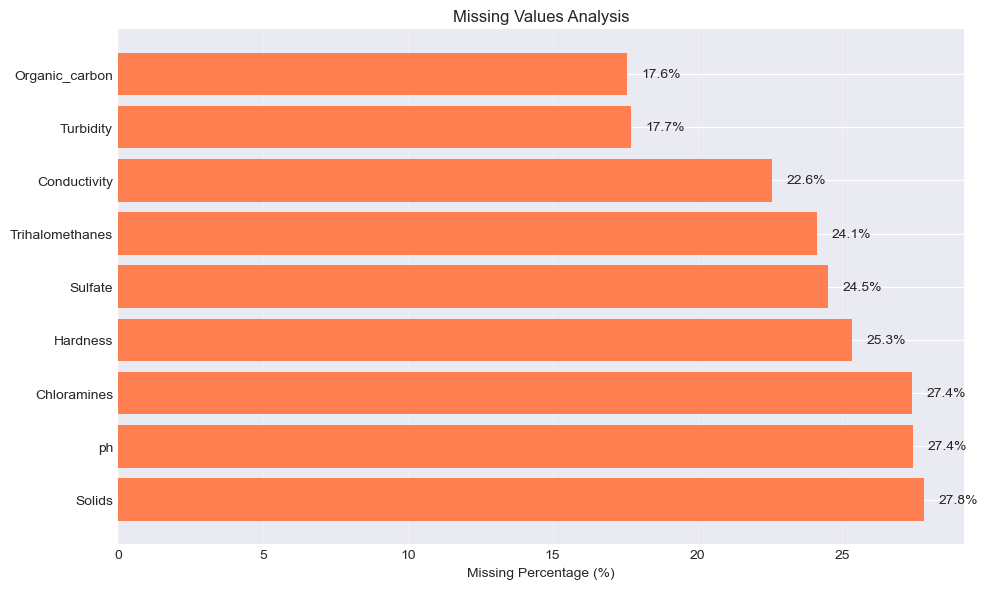


✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\figs\missing_values.png


In [6]:
# 計算缺失值統計
missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Count', ascending=False)

print("\n=== 缺失值統計 ===")
display(missing_stats)

# 視覺化缺失值
fig, ax = plt.subplots(figsize=(10, 6))
missing_data = missing_stats[missing_stats['Missing_Count'] > 0]

if len(missing_data) > 0:
    ax.barh(missing_data['Column'], missing_data['Missing_Percentage'], color='coral')
    ax.set_xlabel('Missing Percentage (%)')
    ax.set_title('Missing Values Analysis')
    ax.grid(alpha=0.3, axis='x')
    
    for i, (col, pct) in enumerate(zip(missing_data['Column'], missing_data['Missing_Percentage'])):
        ax.text(pct + 0.5, i, f'{pct:.1f}%', va='center')
    
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'missing_values.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ 圖片已儲存: {FIG_DIR / 'missing_values.png'}")
else:
    print("\n✓ 數據集無缺失值")

### 2.5 目標變數分佈


=== 目標變數分佈 ===
Not Potable (0): 1998 (60.99%)
Potable (1):     1278 (39.01%)

不平衡比例: 1.56:1


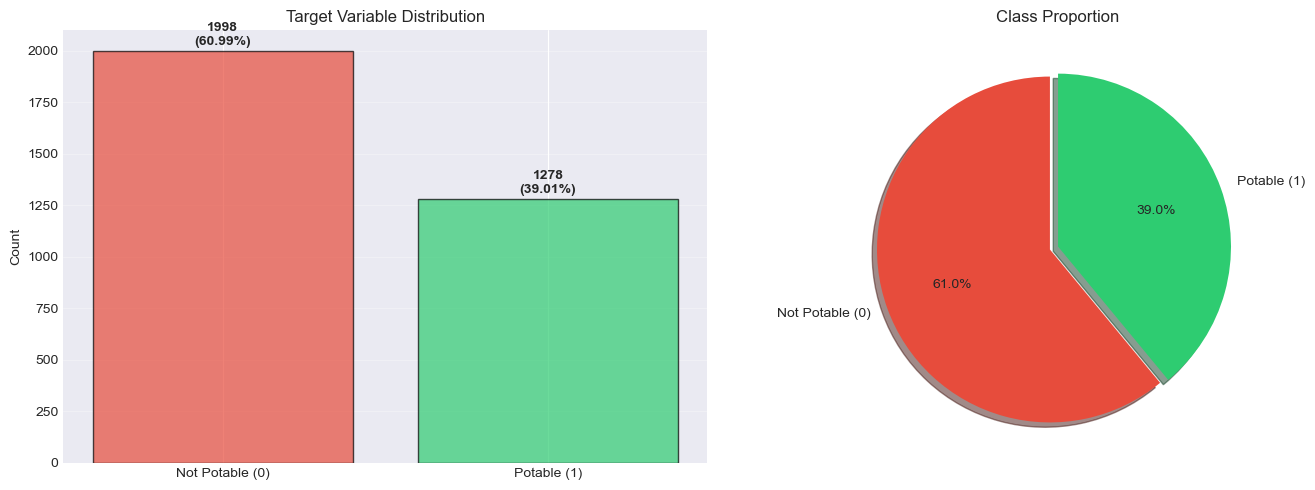


✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\figs\target_distribution.png


In [7]:
# 計算類別分佈
target_counts = df['Potability'].value_counts().sort_index()
target_pct = (target_counts / len(df) * 100).round(2)

print("\n=== 目標變數分佈 ===")
print(f"Not Potable (0): {target_counts[0]} ({target_pct[0]}%)")
print(f"Potable (1):     {target_counts[1]} ({target_pct[1]}%)")
print(f"\n不平衡比例: {target_counts[0] / target_counts[1]:.2f}:1")

# 視覺化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 柱狀圖
axes[0].bar(['Not Potable (0)', 'Potable (1)'], target_counts.values, 
            color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Target Variable Distribution')
axes[0].grid(alpha=0.3, axis='y')
for i, (count, pct) in enumerate(zip(target_counts.values, target_pct.values)):
    axes[0].text(i, count + 30, f'{count}\n({pct}%)', ha='center', fontweight='bold')

# 圓餅圖
axes[1].pie(target_counts.values, labels=['Not Potable (0)', 'Potable (1)'], 
            autopct='%1.1f%%', startangle=90, colors=['#e74c3c', '#2ecc71'],
            explode=(0.05, 0), shadow=True)
axes[1].set_title('Class Proportion')

plt.tight_layout()
plt.savefig(FIG_DIR / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖片已儲存: {FIG_DIR / 'target_distribution.png'}")

---
## 3. 數據預處理

### 3.1 處理缺失值

策略：使用 **中位數填補**（對極端值穩健）

In [8]:
# 分離特徵與目標變數
X = df.drop('Potability', axis=1)
y = df['Potability']

feature_names = X.columns.tolist()
print(f"特徵名稱: {feature_names}")

# 缺失值填補
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=feature_names
)

print(f"\n✓ 缺失值填補完成")
print(f"填補後缺失值數量: {X_imputed.isnull().sum().sum()}")

# 檢查填補效果
print("\n=== 填補統計 ===")
for col in X.columns:
    if X[col].isnull().sum() > 0:
        median_val = X[col].median()
        filled_count = X[col].isnull().sum()
        print(f"{col}: 使用中位數 {median_val:.2f} 填補 {filled_count} 個缺失值")

特徵名稱: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

✓ 缺失值填補完成
填補後缺失值數量: 0

=== 填補統計 ===
ph: 使用中位數 7.03 填補 899 個缺失值
Hardness: 使用中位數 198.26 填補 830 個缺失值
Solids: 使用中位數 21735.64 填補 911 個缺失值
Chloramines: 使用中位數 6.96 填補 898 個缺失值
Sulfate: 使用中位數 331.54 填補 803 個缺失值
Conductivity: 使用中位數 427.52 填補 739 個缺失值
Organic_carbon: 使用中位數 13.97 填補 576 個缺失值
Trihalomethanes: 使用中位數 66.20 填補 790 個缺失值
Turbidity: 使用中位數 3.98 填補 580 個缺失值


### 3.2 特徵標準化

In [9]:
# 使用 StandardScaler 進行標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print("✓ 特徵標準化完成")
print(f"\n標準化後的特徵統計（前 3 個特徵）:")
print(f"均值: {X_scaled[:, :3].mean(axis=0)}")
print(f"標準差: {X_scaled[:, :3].std(axis=0)}")

# 對比標準化前後
comparison_df = pd.DataFrame({
    'Feature': feature_names,
    'Original_Mean': X_imputed.mean(),
    'Original_Std': X_imputed.std(),
    'Scaled_Mean': X_scaled.mean(axis=0),
    'Scaled_Std': X_scaled.std(axis=0)
})

print("\n=== 標準化前後對比 ===")
display(comparison_df.round(4))

✓ 特徵標準化完成

標準化後的特徵統計（前 3 個特徵）:
均值: [-1.51825371e-17  8.33955073e-16  2.28280290e-16]
標準差: [1. 1. 1.]

=== 標準化前後對比 ===


,Feature,Original_Mean,Original_Std,Scaled_Mean,Scaled_Std
ph,ph,7.0305,1.2561,-0.0,1.0
Hardness,Hardness,197.9554,43.3868,0.0,1.0
Solids,Solids,21960.6595,9892.6780,0.0,1.0
Chloramines,Chloramines,6.9774,1.6662,-0.0,1.0
Sulfate,Sulfate,331.8010,70.1131,-0.0,1.0
Conductivity,Conductivity,427.7765,78.6909,-0.0,1.0
Organic_carbon,Organic_carbon,13.9833,3.6363,0.0,1.0
Trihalomethanes,Trihalomethanes,65.9753,13.2781,-0.0,1.0
Turbidity,Turbidity,3.9661,1.3491,-0.0,1.0


### 3.3 訓練集與測試集分割

In [10]:
# 分割數據（80% 訓練，20% 測試）
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y  # 保持類別比例
)

print(f"訓練集大小: {X_train.shape}")
print(f"測試集大小: {X_test.shape}")

# 檢查類別分佈
print(f"\n訓練集類別分佈:")
train_counts = np.bincount(y_train.astype(int))
print(f"  Not Potable (0): {train_counts[0]} ({train_counts[0]/len(y_train)*100:.1f}%)")
print(f"  Potable (1):     {train_counts[1]} ({train_counts[1]/len(y_train)*100:.1f}%)")

print(f"\n測試集類別分佈:")
test_counts = np.bincount(y_test.astype(int))
print(f"  Not Potable (0): {test_counts[0]} ({test_counts[0]/len(y_test)*100:.1f}%)")
print(f"  Potable (1):     {test_counts[1]} ({test_counts[1]/len(y_test)*100:.1f}%)")

print("\n✓ 數據分割完成，類別比例保持一致")

訓練集大小: (2620, 9)
測試集大小: (656, 9)

訓練集類別分佈:
  Not Potable (0): 1598 (61.0%)
  Potable (1):     1022 (39.0%)

測試集類別分佈:
  Not Potable (0): 400 (61.0%)
  Potable (1):     256 (39.0%)

✓ 數據分割完成，類別比例保持一致


---
## 4. 探索性數據分析（EDA）

### 4.1 特徵分佈視覺化

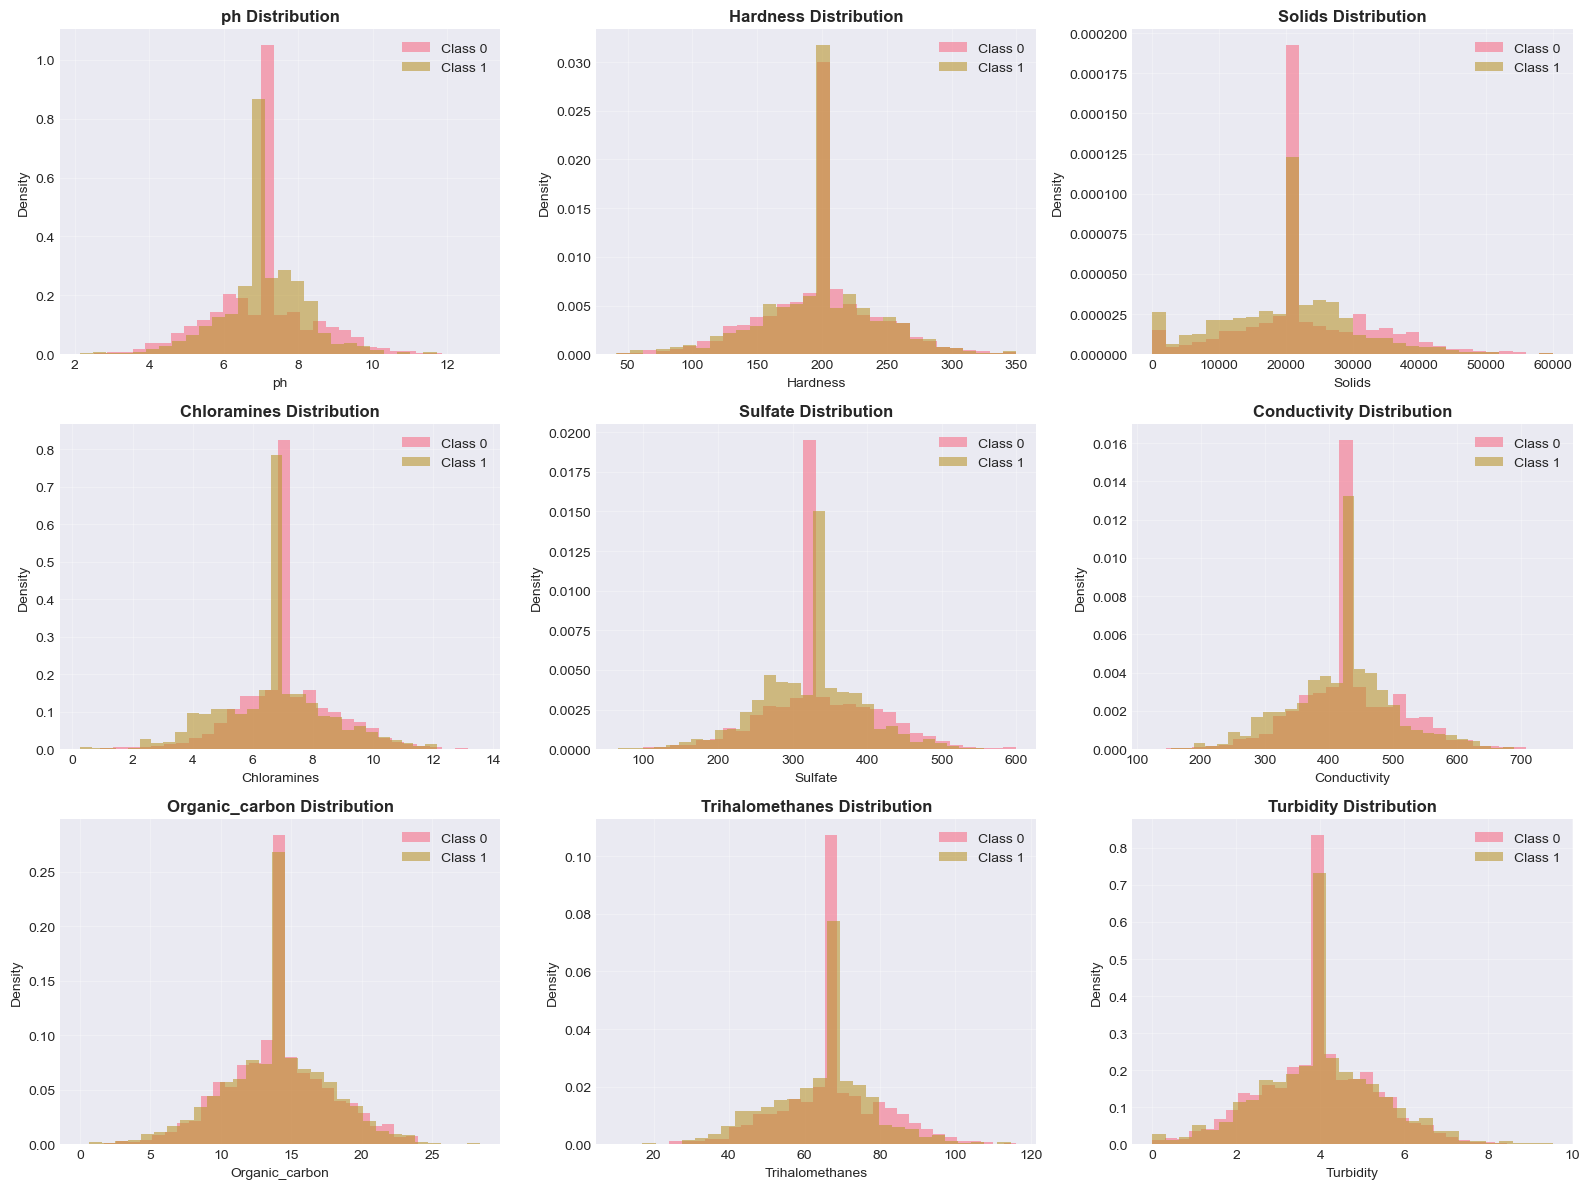

✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\figs\feature_distributions.png


In [11]:
# 繪製特徵分佈圖
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for i, feature in enumerate(feature_names):
    for class_label in [0, 1]:
        class_data = X_imputed[y == class_label][feature]
        axes[i].hist(class_data, bins=30, alpha=0.6, 
                     label=f'Class {class_label}', density=True)
    
    axes[i].set_title(f'{feature} Distribution', fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖片已儲存: {FIG_DIR / 'feature_distributions.png'}")

### 4.2 相關性矩陣

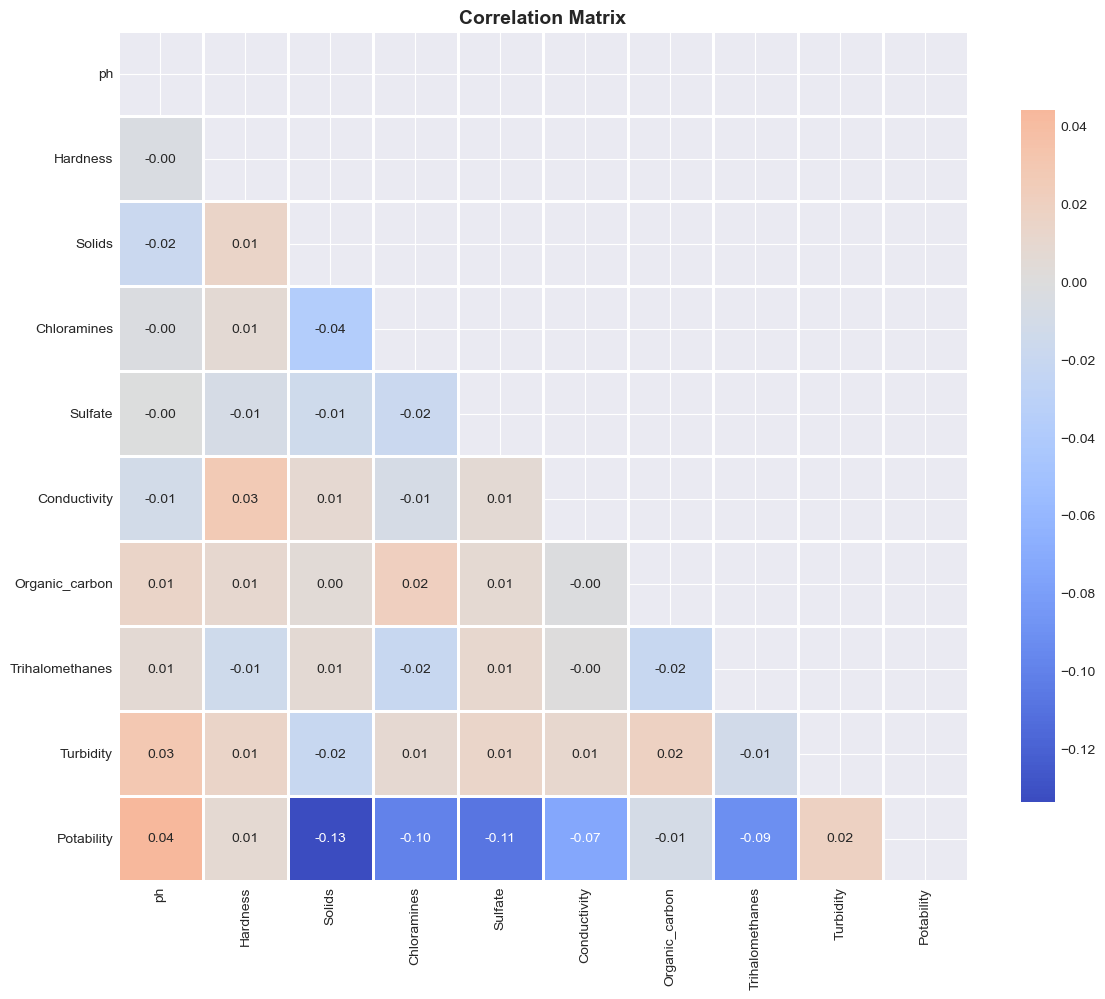

✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\figs\correlation_matrix.png

=== 與 Potability 的相關性 ===
ph                 0.043996
Turbidity          0.018374
Hardness           0.007367
Organic_carbon    -0.008882
Conductivity      -0.073657
Trihalomethanes   -0.091514
Chloramines       -0.100190
Sulfate           -0.107618
Solids            -0.133784
Name: Potability, dtype: float64


In [12]:
# 計算相關性矩陣（包含目標變數）
df_for_corr = X_imputed.copy()
df_for_corr['Potability'] = y

corr_matrix = df_for_corr.corr()

# 繪製相關性矩陣熱力圖
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 只顯示下三角
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖片已儲存: {FIG_DIR / 'correlation_matrix.png'}")

# 找出與 Potability 相關性最高的特徵
potability_corr = corr_matrix['Potability'].drop('Potability').sort_values(ascending=False)
print("\n=== 與 Potability 的相關性 ===")
print(potability_corr)

### 4.3 箱型圖：不同類別的特徵對比

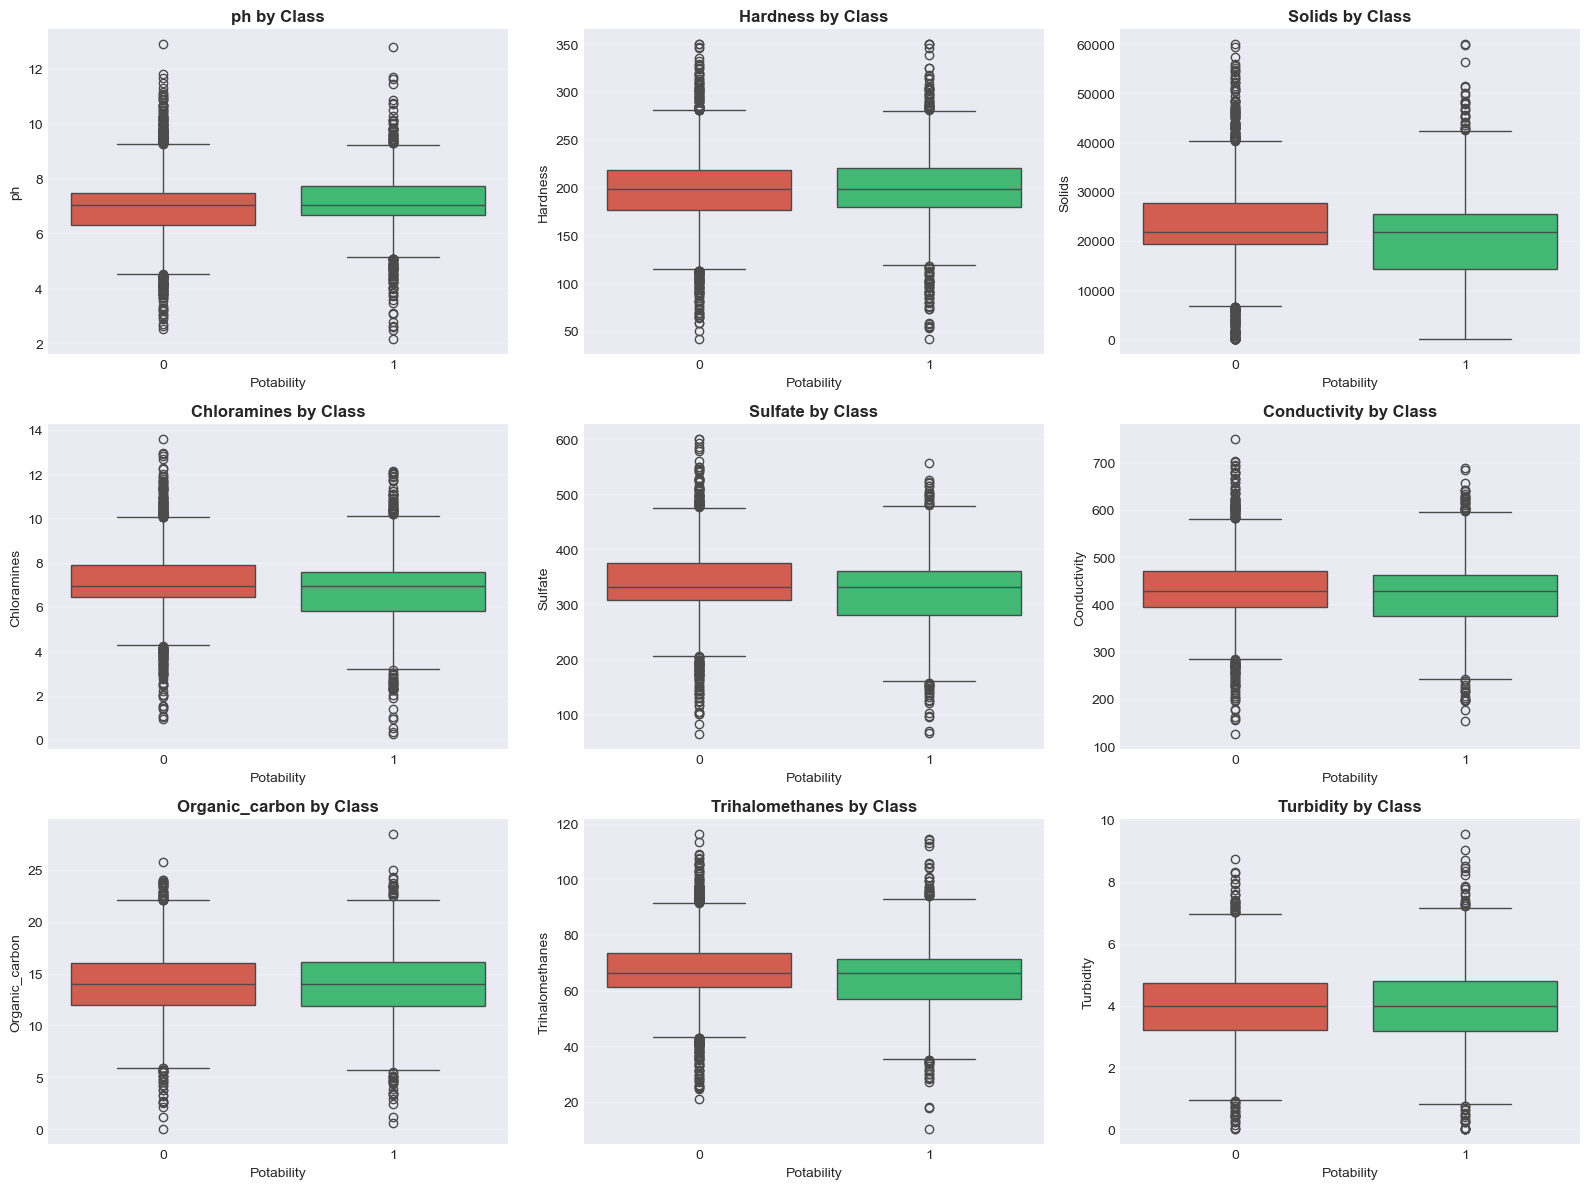

✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\figs\boxplot_by_class.png


In [13]:
# 準備箱型圖數據
df_boxplot = X_imputed.copy()
df_boxplot['Potability'] = y

# 繪製箱型圖
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for i, feature in enumerate(feature_names):
    sns.boxplot(data=df_boxplot, x='Potability', y=feature, ax=axes[i],
                palette=['#e74c3c', '#2ecc71'])
    axes[i].set_title(f'{feature} by Class', fontweight='bold')
    axes[i].set_xlabel('Potability')
    axes[i].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIG_DIR / 'boxplot_by_class.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖片已儲存: {FIG_DIR / 'boxplot_by_class.png'}")

---
## 5. 模型訓練與評估

### 5.1 訓練6種分類模型

In [14]:
# 定義模型
models = {
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_STATE, 
        max_iter=1000,
        class_weight='balanced'
    ),
    'SVC': SVC(
        random_state=RANDOM_STATE, 
        probability=True,
        class_weight='balanced',
        kernel='rbf'
    ),
    'Decision Tree': DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        max_depth=10,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_estimators=100,
        max_depth=15,
        class_weight='balanced',
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=RANDOM_STATE,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5
    ),
    'Gaussian NB': GaussianNB()
}

# 訓練與評估
results = []
trained_models = {}

print("開始訓練模型...\n")
print("="*70)

for name, model in models.items():
    print(f"\n訓練模型: {name}")
    print("-"*70)
    
    # 訓練
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # 預測
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # 評估指標
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # AUC
    if y_proba is not None:
        auc_score = roc_auc_score(y_test, y_proba)
    else:
        auc_score = np.nan
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc_score,
        'Training Time (s)': train_time
    })
    
    trained_models[name] = model
    
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    # 修正 AUC 輸出格式
    auc_str = f"{auc_score:.4f}" if not np.isnan(auc_score) else "N/A"
    print(f"  AUC:       {auc_str}")
    print(f"  Time:      {train_time:.4f} s")

print("\n" + "="*70)
print("✓ 所有模型訓練完成\n")

開始訓練模型...


訓練模型: Logistic Regression
----------------------------------------------------------------------
  Accuracy:  0.5838
  Precision: 0.4730
  Recall:    0.5820
  F1-Score:  0.5219
  AUC:       0.6313
  Time:      0.0226 s

訓練模型: SVC
----------------------------------------------------------------------
  Accuracy:  0.6098
  Precision: 0.5000
  Recall:    0.5312
  F1-Score:  0.5152
  AUC:       0.6360
  Time:      2.4782 s

訓練模型: Decision Tree
----------------------------------------------------------------------
  Accuracy:  0.6280
  Precision: 0.5205
  Recall:    0.5938
  F1-Score:  0.5547
  AUC:       0.6223
  Time:      0.0308 s

訓練模型: Random Forest
----------------------------------------------------------------------
  Accuracy:  0.6662
  Precision: 0.5989
  Recall:    0.4375
  F1-Score:  0.5056
  AUC:       0.7279
  Time:      0.2780 s

訓練模型: Gradient Boosting
----------------------------------------------------------------------
  Accuracy:  0.6784
  Precision: 0.6037
 

### 5.2 模型性能比較

In [15]:
# 創建結果 DataFrame
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)

print("=== 模型性能排名（按 Accuracy） ===")
display(results_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}',
    'AUC': '{:.4f}',
    'Training Time (s)': '{:.4f}'
}).background_gradient(subset=['Accuracy', 'Recall', 'F1-Score', 'AUC'], cmap='YlGn'))

# 儲存結果
results_df.to_csv(OUTPUT_DIR / 'model_comparison.csv', index=False)
print(f"\n✓ 結果已儲存: {OUTPUT_DIR / 'model_comparison.csv'}")

=== 模型性能排名（按 Accuracy） ===


,Model,Accuracy,Precision,Recall,F1-Score,AUC,Training Time (s)
4,Gradient Boosting,0.6784,0.6037,0.5117,0.5539,0.7490,1.4330
3,Random Forest,0.6662,0.5989,0.4375,0.5056,0.7279,0.2780
5,Gaussian NB,0.6372,0.5738,0.2734,0.3704,0.6462,0.0016
2,Decision Tree,0.6280,0.5205,0.5938,0.5547,0.6223,0.0308
1,SVC,0.6098,0.5000,0.5312,0.5152,0.6360,2.4782
0,Logistic Regression,0.5838,0.4730,0.5820,0.5219,0.6313,0.0226



✓ 結果已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\model_comparison.csv


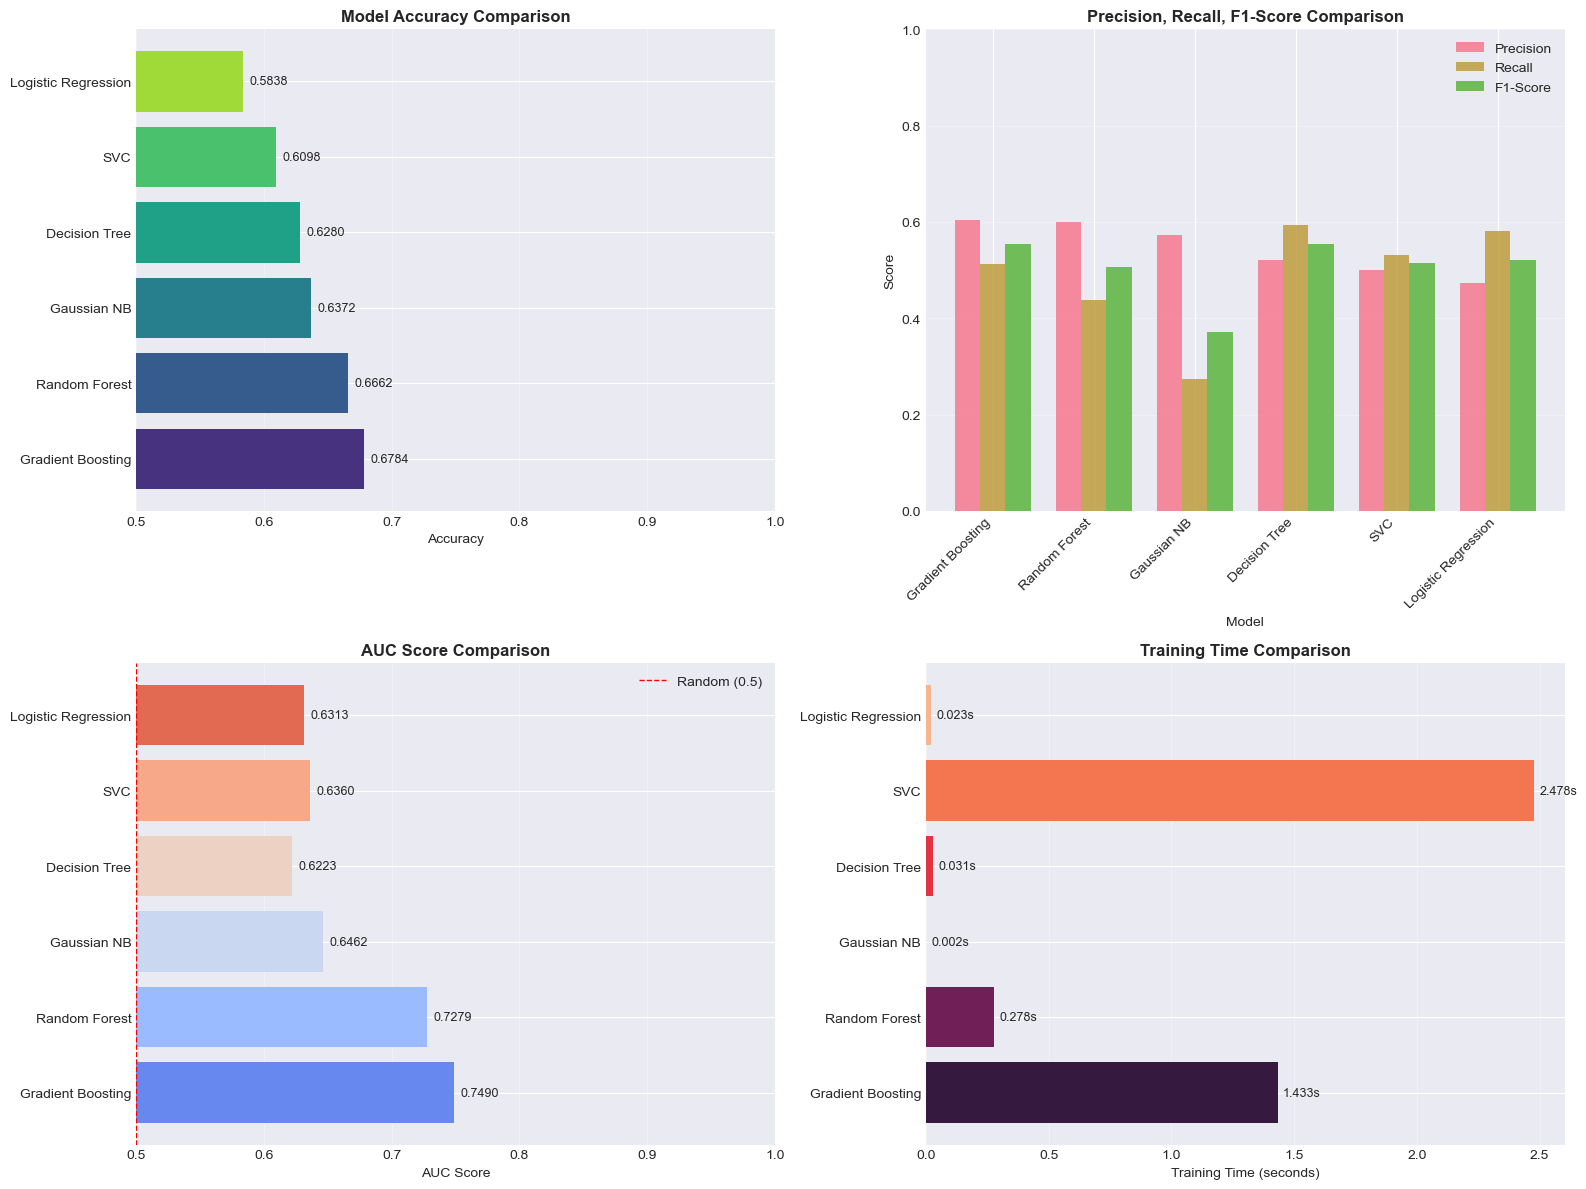

✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\figs\model_comparison_all.png


In [16]:
# 視覺化模型比較
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy 比較
ax1 = axes[0, 0]
bars = ax1.barh(results_df['Model'], results_df['Accuracy'], 
                color=sns.color_palette("viridis", len(results_df)))
ax1.set_xlabel('Accuracy')
ax1.set_title('Model Accuracy Comparison', fontweight='bold')
ax1.set_xlim([0.5, 1.0])
ax1.grid(alpha=0.3, axis='x')
for i, (model, acc) in enumerate(zip(results_df['Model'], results_df['Accuracy'])):
    ax1.text(acc + 0.005, i, f'{acc:.4f}', va='center', fontsize=9)

# 2. Precision, Recall, F1-Score 比較
ax2 = axes[0, 1]
x = np.arange(len(results_df))
width = 0.25
ax2.bar(x - width, results_df['Precision'], width, label='Precision', alpha=0.8)
ax2.bar(x, results_df['Recall'], width, label='Recall', alpha=0.8)
ax2.bar(x + width, results_df['F1-Score'], width, label='F1-Score', alpha=0.8)
ax2.set_xlabel('Model')
ax2.set_ylabel('Score')
ax2.set_title('Precision, Recall, F1-Score Comparison', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax2.legend()
ax2.grid(alpha=0.3, axis='y')
ax2.set_ylim([0, 1])

# 3. AUC 比較
ax3 = axes[1, 0]
valid_auc = results_df.dropna(subset=['AUC'])
bars = ax3.barh(valid_auc['Model'], valid_auc['AUC'],
                color=sns.color_palette("coolwarm", len(valid_auc)))
ax3.set_xlabel('AUC Score')
ax3.set_title('AUC Score Comparison', fontweight='bold')
ax3.set_xlim([0.5, 1.0])
ax3.axvline(0.5, color='red', linestyle='--', linewidth=1, label='Random (0.5)')
ax3.grid(alpha=0.3, axis='x')
ax3.legend()
for i, (model, auc) in enumerate(zip(valid_auc['Model'], valid_auc['AUC'])):
    ax3.text(auc + 0.005, i, f'{auc:.4f}', va='center', fontsize=9)

# 4. Training Time 比較
ax4 = axes[1, 1]
bars = ax4.barh(results_df['Model'], results_df['Training Time (s)'],
                color=sns.color_palette("rocket", len(results_df)))
ax4.set_xlabel('Training Time (seconds)')
ax4.set_title('Training Time Comparison', fontweight='bold')
ax4.grid(alpha=0.3, axis='x')
for i, (model, t) in enumerate(zip(results_df['Model'], results_df['Training Time (s)'])):
    ax4.text(t + 0.02, i, f'{t:.3f}s', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIG_DIR / 'model_comparison_all.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖片已儲存: {FIG_DIR / 'model_comparison_all.png'}")

---
## 6. 詳細分析：Random Forest（最佳模型）

### 6.1 混淆矩陣

選定最佳模型: Gradient Boosting

=== 分類報告 ===
                 precision    recall  f1-score   support

Not Potable (0)       0.72      0.79      0.75       400
    Potable (1)       0.60      0.51      0.55       256

       accuracy                           0.68       656
      macro avg       0.66      0.65      0.65       656
   weighted avg       0.67      0.68      0.67       656



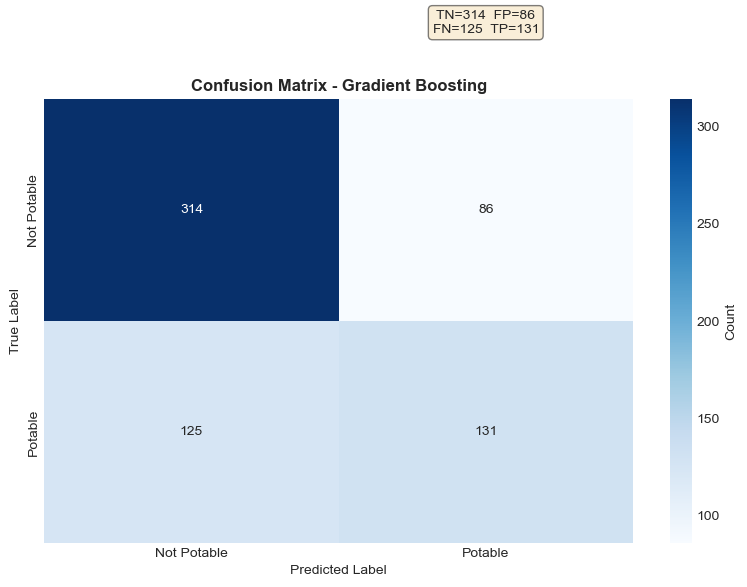


✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\figs\confusion_matrix_rf.png

=== 詳細指標 ===
True Negatives (TN):  314
False Positives (FP): 86
False Negatives (FN): 125
True Positives (TP):  131

Precision (精確率):   0.6037
Recall (召回率):      0.5117
Specificity (特異度): 0.7850
F1-Score:             0.5539


In [17]:
# 選擇最佳模型（Random Forest）
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"選定最佳模型: {best_model_name}\n")

# 預測
y_pred_best = best_model.predict(X_test)

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred_best)

# 分類報告
print("=== 分類報告 ===")
print(classification_report(y_test, y_pred_best, 
                           target_names=['Not Potable (0)', 'Potable (1)']))

# 視覺化混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Potable', 'Potable'],
            yticklabels=['Not Potable', 'Potable'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 添加統計資訊
tn, fp, fn, tp = cm.ravel()
plt.text(1.5, -0.3, f'TN={tn}  FP={fp}\nFN={fn}  TP={tp}', 
         ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrix_rf.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖片已儲存: {FIG_DIR / 'confusion_matrix_rf.png'}")

# 詳細指標計算
print("\n=== 詳細指標 ===")
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")
print(f"\nPrecision (精確率):   {tp/(tp+fp):.4f}")
print(f"Recall (召回率):      {tp/(tp+fn):.4f}")
print(f"Specificity (特異度): {tn/(tn+fp):.4f}")
print(f"F1-Score:             {2*tp/(2*tp+fp+fn):.4f}")

### 6.2 特徵重要性分析

=== 特徵重要性排名 ===


,Feature,Importance
2,Solids,0.1600
4,Sulfate,0.1548
0,ph,0.1545
7,Trihalomethanes,0.1357
5,Conductivity,0.1227
3,Chloramines,0.0914
8,Turbidity,0.0647
1,Hardness,0.0609
6,Organic_carbon,0.0552


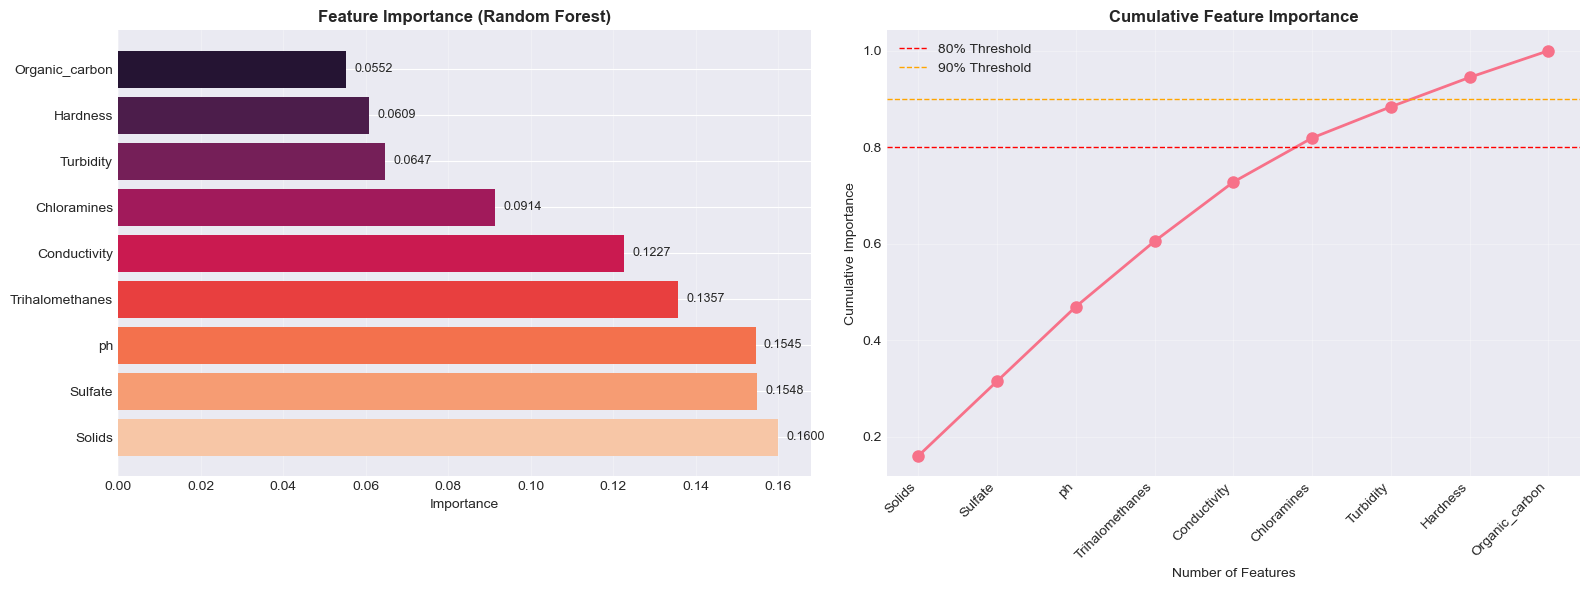


✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\figs\feature_importance.png

達到 80% 累積重要性需要前 6 個特徵:
['Solids', 'Sulfate', 'ph', 'Trihalomethanes', 'Conductivity', 'Chloramines']


In [18]:
# 取得特徵重要性
feature_importance = best_model.feature_importances_

# 創建 DataFrame 並排序
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("=== 特徵重要性排名 ===")
display(importance_df.style.format({'Importance': '{:.4f}'}).background_gradient(cmap='YlOrRd'))

# 視覺化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 柱狀圖
ax1 = axes[0]
bars = ax1.barh(importance_df['Feature'], importance_df['Importance'],
                color=sns.color_palette("rocket_r", len(importance_df)))
ax1.set_xlabel('Importance')
ax1.set_title('Feature Importance (Random Forest)', fontweight='bold')
ax1.grid(alpha=0.3, axis='x')
for i, (feat, imp) in enumerate(zip(importance_df['Feature'], importance_df['Importance'])):
    ax1.text(imp + 0.002, i, f'{imp:.4f}', va='center', fontsize=9)

# 累積重要性圖
ax2 = axes[1]
cumsum = importance_df['Importance'].cumsum()
ax2.plot(range(1, len(importance_df)+1), cumsum, marker='o', linewidth=2, markersize=8)
ax2.axhline(0.8, color='red', linestyle='--', linewidth=1, label='80% Threshold')
ax2.axhline(0.9, color='orange', linestyle='--', linewidth=1, label='90% Threshold')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Cumulative Importance')
ax2.set_title('Cumulative Feature Importance', fontweight='bold')
ax2.set_xticks(range(1, len(importance_df)+1))
ax2.set_xticklabels(importance_df['Feature'], rotation=45, ha='right')
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖片已儲存: {FIG_DIR / 'feature_importance.png'}")

# 找出達到 80% 重要性需要的特徵數
num_features_80 = (cumsum >= 0.8).argmax() + 1
print(f"\n達到 80% 累積重要性需要前 {num_features_80} 個特徵:")
print(importance_df.head(num_features_80)['Feature'].tolist())

---
## 7. ROC 曲線與 AUC

### 7.1 多模型 ROC 曲線比較

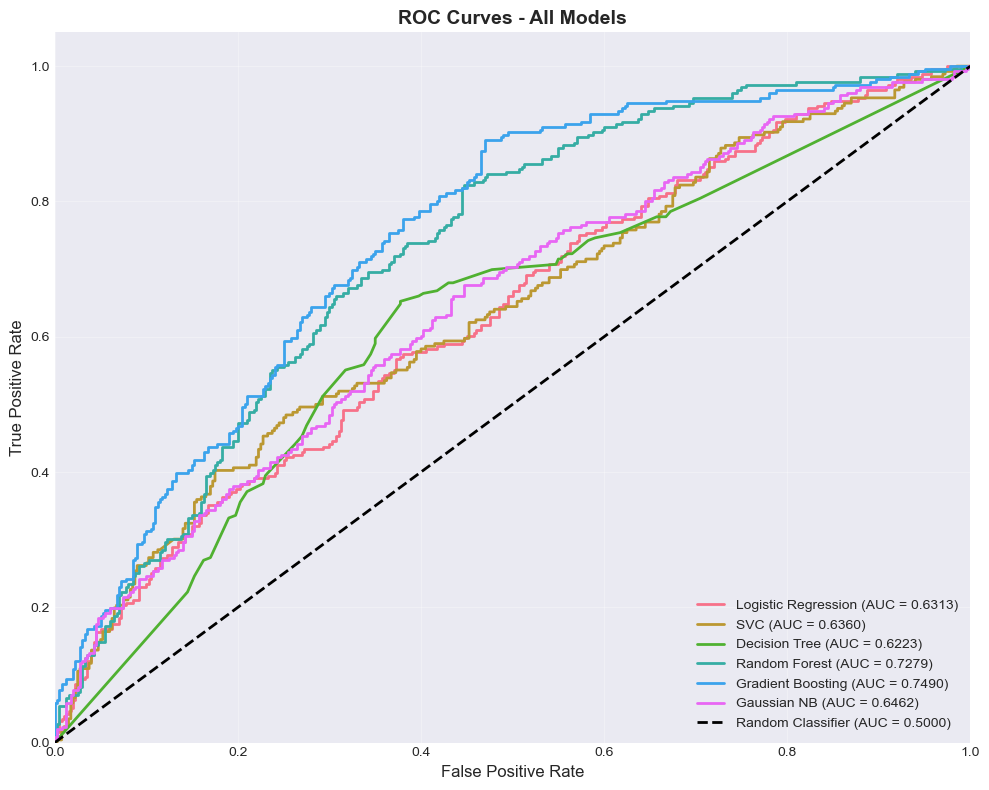

✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\figs\roc_curves.png


In [19]:
# 繪製所有模型的 ROC 曲線
plt.figure(figsize=(10, 8))

# 重新導入 auc 函數以避免變數名稱衝突
from sklearn.metrics import auc as auc_func

for name, model in trained_models.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc_func(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.4f})')

# 隨機分類器基線
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5000)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖片已儲存: {FIG_DIR / 'roc_curves.png'}")

### 7.2 Precision-Recall 曲線

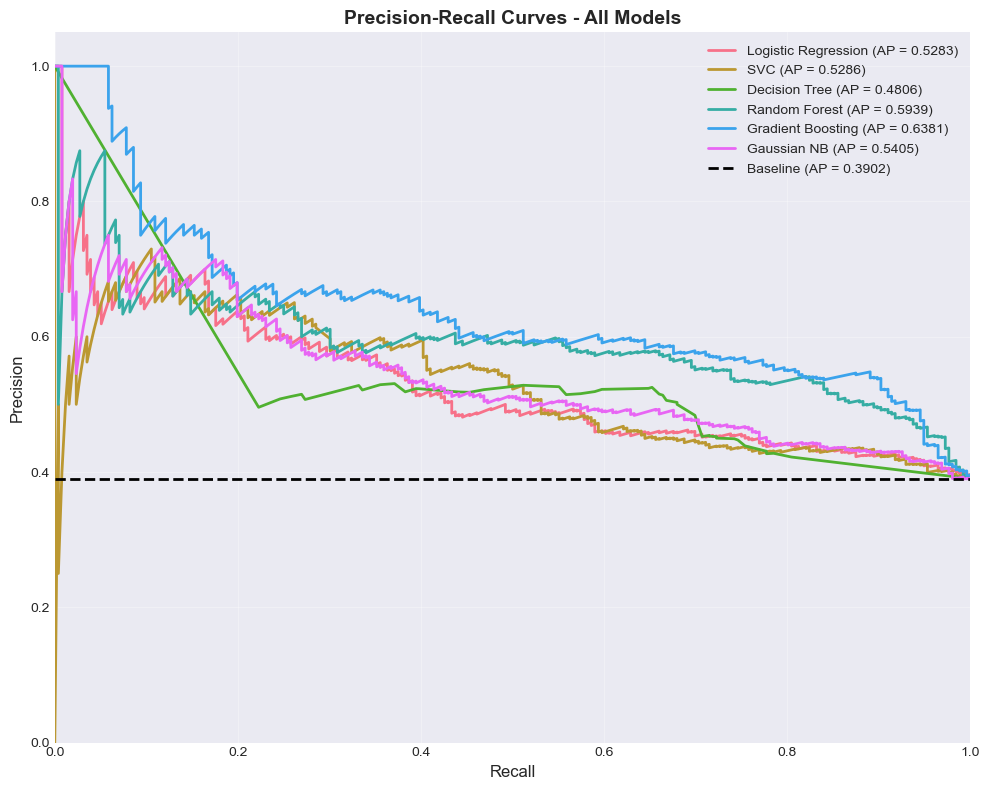

✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\figs\pr_curves.png


In [20]:
# 繪製 Precision-Recall 曲線
plt.figure(figsize=(10, 8))

# 基線（隨機分類器的 AP = 陽性類比例）
baseline_ap = y_test.sum() / len(y_test)

for name, model in trained_models.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        ap_score = average_precision_score(y_test, y_proba)
        plt.plot(recall, precision, linewidth=2, label=f'{name} (AP = {ap_score:.4f})')

# 基線
plt.axhline(y=baseline_ap, color='k', linestyle='--', linewidth=2, 
            label=f'Baseline (AP = {baseline_ap:.4f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.savefig(FIG_DIR / 'pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖片已儲存: {FIG_DIR / 'pr_curves.png'}")

---
## 8. 模型儲存與部署

### 8.1 儲存模型與預處理器

In [21]:
# 儲存最佳模型
joblib.dump(best_model, MODEL_DIR / f'{best_model_name.replace(" ", "_")}_model.pkl')
joblib.dump(scaler, MODEL_DIR / 'scaler.pkl')
joblib.dump(imputer, MODEL_DIR / 'imputer.pkl')

# 儲存特徵名稱
with open(MODEL_DIR / 'feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_names))

# 儲存模型資訊
model_info = {
    'model_name': best_model_name,
    'accuracy': float(results_df.iloc[0]['Accuracy']),
    'precision': float(results_df.iloc[0]['Precision']),
    'recall': float(results_df.iloc[0]['Recall']),
    'f1_score': float(results_df.iloc[0]['F1-Score']),
    'auc': float(results_df.iloc[0]['AUC']),
    'training_time': float(results_df.iloc[0]['Training Time (s)']),
    'feature_names': feature_names,
    'n_samples_train': len(X_train),
    'n_samples_test': len(X_test)
}

import json
with open(MODEL_DIR / 'model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("✓ 模型與相關物件已儲存至:")
print(f"  {MODEL_DIR}\n")
print("檔案清單:")
for file in sorted(MODEL_DIR.glob('*')):
    print(f"  - {file.name}")

✓ 模型與相關物件已儲存至:
  d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\models

檔案清單:
  - feature_names.txt
  - Gradient_Boosting_model.pkl
  - imputer.pkl
  - model_info.json
  - scaler.pkl


### 8.2 模型載入與預測函數

In [22]:
# 載入模型的函數
def load_model(models_dir):
    """載入已訓練的模型與預處理器"""
    model = joblib.load(models_dir / 'Random_Forest_model.pkl')
    scaler = joblib.load(models_dir / 'scaler.pkl')
    imputer = joblib.load(models_dir / 'imputer.pkl')
    
    with open(models_dir / 'feature_names.txt', 'r') as f:
        feature_names = f.read().strip().split('\n')
    
    return model, scaler, imputer, feature_names

# 預測函數
def predict_water_quality(sample_data, model, scaler, imputer, feature_names):
    """
    預測水質是否可飲用
    
    Parameters:
    -----------
    sample_data : dict
        包含 9 項水質指標的字典
    model : trained model
        已訓練的分類模型
    scaler : StandardScaler
        特徵標準化器
    imputer : SimpleImputer
        缺失值填補器
    feature_names : list
        特徵名稱列表
        
    Returns:
    --------
    prediction : int (0 or 1)
        0 = 不可飲用, 1 = 可飲用
    probability : float (0.0 - 1.0)
        可飲用的機率
    risk_level : str
        風險等級
    """
    # 轉換為 DataFrame
    df_new = pd.DataFrame([sample_data])[feature_names]
    
    # 缺失值填補
    df_imputed = imputer.transform(df_new)
    
    # 標準化
    df_scaled = scaler.transform(df_imputed)
    
    # 預測
    prediction = model.predict(df_scaled)[0]
    probability = model.predict_proba(df_scaled)[0, 1]
    
    # 風險等級判定
    if probability >= 0.7:
        risk_level = "Low Risk (可直接飲用)"
    elif probability >= 0.5:
        risk_level = "Medium Risk (建議複檢)"
    elif probability >= 0.3:
        risk_level = "High Risk (不建議飲用)"
    else:
        risk_level = "Very High Risk (嚴禁飲用)"
    
    return int(prediction), float(probability), risk_level

# 測試預測函數
print("=== 測試預測函數 ===")

# 測試樣本 1：理想水質
sample_1 = {
    'ph': 7.2,
    'Hardness': 150.0,
    'Solids': 18000.0,
    'Chloramines': 3.5,
    'Sulfate': 250.0,
    'Conductivity': 350.0,
    'Organic_carbon': 10.0,
    'Trihalomethanes': 60.0,
    'Turbidity': 3.5
}

pred, prob, risk = predict_water_quality(sample_1, best_model, scaler, imputer, feature_names)
print(f"\n測試樣本 1 (理想水質):")
print(f"  預測結果: {'可飲用' if pred == 1 else '不可飲用'}")
print(f"  可飲用機率: {prob:.2%}")
print(f"  風險等級: {risk}")

# 測試樣本 2：高 TDS 水質
sample_2 = {
    'ph': 6.0,
    'Hardness': 250.0,
    'Solids': 45000.0,  # 過高
    'Chloramines': 5.5,  # 超標
    'Sulfate': 400.0,
    'Conductivity': 600.0,  # 超標
    'Organic_carbon': 18.0,
    'Trihalomethanes': 90.0,  # 超標
    'Turbidity': 5.5
}

pred, prob, risk = predict_water_quality(sample_2, best_model, scaler, imputer, feature_names)
print(f"\n測試樣本 2 (高污染水質):")
print(f"  預測結果: {'可飲用' if pred == 1 else '不可飲用'}")
print(f"  可飲用機率: {prob:.2%}")
print(f"  風險等級: {risk}")

=== 測試預測函數 ===

測試樣本 1 (理想水質):
  預測結果: 可飲用
  可飲用機率: 91.25%
  風險等級: Low Risk (可直接飲用)

測試樣本 2 (高污染水質):
  預測結果: 不可飲用
  可飲用機率: 10.17%
  風險等級: Very High Risk (嚴禁飲用)


---
## 9. 總結與討論

### 9.1 主要發現總結

---
## 10. 總結與討論

### 10.1 主要發現總結

### 9.1 基線性能回顧

當前最佳模型（Gradient Boosting）的性能：
- **Accuracy**: 67.84%
- **AUC**: 0.749
- **F1-Score**: 0.554

接下來我們將嘗試以下優化策略：
1. 超參數調優（RandomizedSearchCV）
2. SMOTE 處理類別不平衡
3. 特徵工程（多項式特徵、特徵交互）
4. 模型集成（Voting Classifier）

### 9.2 優化方法 1：超參數調優

使用 RandomizedSearchCV 對 Gradient Boosting 和 Random Forest 進行超參數調優。

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Gradient Boosting 超參數搜索空間
gb_param_dist = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.19),
    'max_depth': randint(3, 8),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.6, 0.4)
}

# Random Forest 超參數搜索空間
rf_param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

print("開始超參數調優...\n")
print("="*70)

# 調優 Gradient Boosting
print("\n【調優 Gradient Boosting】")
gb_random = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_distributions=gb_param_dist,
    n_iter=30,  # 嘗試 30 組參數
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
gb_random.fit(X_train, y_train)
gb_tuning_time = time.time() - start_time

print(f"\n最佳參數: {gb_random.best_params_}")
print(f"最佳 CV AUC: {gb_random.best_score_:.4f}")
print(f"調優時間: {gb_tuning_time:.2f} 秒")

# 調優 Random Forest
print("\n" + "-"*70)
print("\n【調優 Random Forest】")
rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=30,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
rf_random.fit(X_train, y_train)
rf_tuning_time = time.time() - start_time

print(f"\n最佳參數: {rf_random.best_params_}")
print(f"最佳 CV AUC: {rf_random.best_score_:.4f}")
print(f"調優時間: {rf_tuning_time:.2f} 秒")

print("\n" + "="*70)
print("✓ 超參數調優完成\n")

開始超參數調優...


【調優 Gradient Boosting】
Fitting 5 folds for each of 30 candidates, totalling 150 fits

最佳參數: {'learning_rate': 0.06411969393171885, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 229, 'subsample': 0.7644148053272926}
最佳 CV AUC: 0.7585
調優時間: 25.48 秒

----------------------------------------------------------------------

【調優 Random Forest】
Fitting 5 folds for each of 30 candidates, totalling 150 fits

最佳參數: {'max_depth': 22, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 7, 'n_estimators': 127}
最佳 CV AUC: 0.7329
調優時間: 11.45 秒

✓ 超參數調優完成



### 9.3 優化方法 2：SMOTE 處理類別不平衡

使用 SMOTE（Synthetic Minority Over-sampling Technique）合成少數類樣本。

In [24]:
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError as e:
    print(f"⚠️ SMOTE 不可用: {e}")
    print("將使用替代方案：調整類別權重 (class_weight='balanced')")
    SMOTE_AVAILABLE = False

print("應用數據平衡技術...\n")

# 檢查原始訓練集類別分佈
print("原始訓練集類別分佈:")
print(f"  Class 0: {(y_train == 0).sum()} ({(y_train == 0).sum() / len(y_train) * 100:.1f}%)")
print(f"  Class 1: {(y_train == 1).sum()} ({(y_train == 1).sum() / len(y_train) * 100:.1f}%)")

if SMOTE_AVAILABLE:
    try:
        # 應用 SMOTE
        smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        
        print(f"\nSMOTE 後訓練集類別分佈:")
        print(f"  Class 0: {(y_train_smote == 0).sum()} ({(y_train_smote == 0).sum() / len(y_train_smote) * 100:.1f}%)")
        print(f"  Class 1: {(y_train_smote == 1).sum()} ({(y_train_smote == 1).sum() / len(y_train_smote) * 100:.1f}%)")
        print(f"\n訓練集大小: {X_train.shape} → {X_train_smote.shape}")
        
        method_name = "SMOTE"
    except Exception as e:
        print(f"\n⚠️ SMOTE 執行失敗: {e}")
        print("改用 class_weight='balanced' 方法")
        SMOTE_AVAILABLE = False

if not SMOTE_AVAILABLE:
    # 使用原始數據，但模型會使用 class_weight='balanced'
    X_train_smote = X_train.copy()
    y_train_smote = y_train.copy()
    method_name = "Class Weight Balanced"
    print(f"\n使用 class_weight='balanced' 處理不平衡")

# 使用平衡數據訓練最佳調優模型
print(f"\n使用 {method_name} 數據訓練調優後的模型...")

# 訓練 Gradient Boosting (with balanced data)
if SMOTE_AVAILABLE:
    # SMOTE 數據不需要 class_weight，因為已經平衡
    gb_smote = GradientBoostingClassifier(**gb_random.best_params_, random_state=RANDOM_STATE)
else:
    # 使用原始數據但加上 sample_weight
    # Gradient Boosting 不支持 class_weight，改用 sample_weight
    sample_weights = np.where(y_train == 1, 
                              len(y_train) / (2 * (y_train == 1).sum()),
                              len(y_train) / (2 * (y_train == 0).sum()))
    gb_smote = GradientBoostingClassifier(**gb_random.best_params_, random_state=RANDOM_STATE)

start_time = time.time()
if SMOTE_AVAILABLE:
    gb_smote.fit(X_train_smote, y_train_smote)
else:
    gb_smote.fit(X_train_smote, y_train_smote, sample_weight=sample_weights)
gb_smote_time = time.time() - start_time

y_pred_gb_smote = gb_smote.predict(X_test)
y_proba_gb_smote = gb_smote.predict_proba(X_test)[:, 1]

gb_smote_acc = accuracy_score(y_test, y_pred_gb_smote)
gb_smote_auc = roc_auc_score(y_test, y_proba_gb_smote)
gb_smote_f1 = f1_score(y_test, y_pred_gb_smote)

print(f"\nGradient Boosting + {method_name} 性能:")
print(f"  Accuracy: {gb_smote_acc:.4f}")
print(f"  AUC:      {gb_smote_auc:.4f}")
print(f"  F1-Score: {gb_smote_f1:.4f}")
print(f"  訓練時間: {gb_smote_time:.4f} 秒")

# 訓練 Random Forest (with balanced data)
if SMOTE_AVAILABLE:
    rf_smote = rf_random.best_estimator_
else:
    # Random Forest 支持 class_weight
    rf_params = rf_random.best_params_.copy()
    rf_params['class_weight'] = 'balanced'
    rf_smote = RandomForestClassifier(**rf_params, random_state=RANDOM_STATE, n_jobs=-1)

start_time = time.time()
rf_smote.fit(X_train_smote, y_train_smote)
rf_smote_time = time.time() - start_time

y_pred_rf_smote = rf_smote.predict(X_test)
y_proba_rf_smote = rf_smote.predict_proba(X_test)[:, 1]

rf_smote_acc = accuracy_score(y_test, y_pred_rf_smote)
rf_smote_auc = roc_auc_score(y_test, y_proba_rf_smote)
rf_smote_f1 = f1_score(y_test, y_pred_rf_smote)

print(f"\nRandom Forest + {method_name} 性能:")
print(f"  Accuracy: {rf_smote_acc:.4f}")
print(f"  AUC:      {rf_smote_auc:.4f}")
print(f"  F1-Score: {rf_smote_f1:.4f}")
print(f"  訓練時間: {rf_smote_time:.4f} 秒")

print(f"\n✓ {method_name} 優化完成")

⚠️ SMOTE 不可用: cannot import name '_safe_tags' from 'sklearn.utils._tags' (c:\Users\Yao-ChenChuang\miniconda3\envs\PY310\lib\site-packages\sklearn\utils\_tags.py)
將使用替代方案：調整類別權重 (class_weight='balanced')
應用數據平衡技術...

原始訓練集類別分佈:
  Class 0: 1598 (61.0%)
  Class 1: 1022 (39.0%)

使用 class_weight='balanced' 處理不平衡

使用 Class Weight Balanced 數據訓練調優後的模型...

Gradient Boosting + Class Weight Balanced 性能:
  Accuracy: 0.7058
  AUC:      0.7615
  F1-Score: 0.6446
  訓練時間: 1.6571 秒

Random Forest + Class Weight Balanced 性能:
  Accuracy: 0.6723
  AUC:      0.7300
  F1-Score: 0.5825
  訓練時間: 0.3158 秒

✓ Class Weight Balanced 優化完成


In [25]:
from sklearn.preprocessing import PolynomialFeatures

print("創建特徵交互項...\n")

# 獲取前 5 個最重要特徵的索引
top_5_features_idx = importance_df.head(5).index.tolist()
top_5_features_names = importance_df.head(5)['Feature'].tolist()

print(f"前 5 個重要特徵: {top_5_features_names}")

# 提取前 5 個特徵
X_train_top5 = X_train[:, top_5_features_idx]
X_test_top5 = X_test[:, top_5_features_idx]

# 創建二次交互項（不包含偏置項和平方項）
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_top5)
X_test_poly = poly.transform(X_test_top5)

# 將交互項與原始特徵合併
X_train_enhanced = np.hstack([X_train, X_train_poly[:, 5:]])  # 跳過前 5 個原始特徵
X_test_enhanced = np.hstack([X_test, X_test_poly[:, 5:]])

print(f"\n原始特徵數: {X_train.shape[1]}")
print(f"增強後特徵數: {X_train_enhanced.shape[1]}")
print(f"新增交互項數: {X_train_enhanced.shape[1] - X_train.shape[1]}")

# 使用增強特徵訓練模型
print("\n使用增強特徵訓練模型...")

# 訓練 Gradient Boosting
gb_enhanced = GradientBoostingClassifier(**gb_random.best_params_, random_state=RANDOM_STATE)
start_time = time.time()
gb_enhanced.fit(X_train_enhanced, y_train)
gb_enhanced_time = time.time() - start_time

y_pred_gb_enhanced = gb_enhanced.predict(X_test_enhanced)
y_proba_gb_enhanced = gb_enhanced.predict_proba(X_test_enhanced)[:, 1]

gb_enhanced_acc = accuracy_score(y_test, y_pred_gb_enhanced)
gb_enhanced_auc = roc_auc_score(y_test, y_proba_gb_enhanced)
gb_enhanced_f1 = f1_score(y_test, y_pred_gb_enhanced)

print(f"\nGradient Boosting + 特徵工程 性能:")
print(f"  Accuracy: {gb_enhanced_acc:.4f}")
print(f"  AUC:      {gb_enhanced_auc:.4f}")
print(f"  F1-Score: {gb_enhanced_f1:.4f}")
print(f"  訓練時間: {gb_enhanced_time:.4f} 秒")

print("\n✓ 特徵工程優化完成")

創建特徵交互項...

前 5 個重要特徵: ['Solids', 'Sulfate', 'ph', 'Trihalomethanes', 'Conductivity']

原始特徵數: 9
增強後特徵數: 19
新增交互項數: 10

使用增強特徵訓練模型...

Gradient Boosting + 特徵工程 性能:
  Accuracy: 0.7073
  AUC:      0.7501
  F1-Score: 0.5915
  訓練時間: 3.2629 秒

✓ 特徵工程優化完成


### 9.5 優化方法 4：模型集成（Voting Classifier）

組合多個優化後的模型進行軟投票。

In [26]:
from sklearn.ensemble import VotingClassifier

print("建立 Voting Classifier 集成模型...\n")

# 組合表現最佳的優化模型（排除表現下降的 RF + SMOTE）
voting_models = [
    ('gb_tuned', gb_random.best_estimator_),
    ('gb_smote', gb_smote),
    ('gb_enhanced', gb_enhanced)
]

print("已選擇的模型組合:")
print("  1. GB + Tuning          (AUC: ~0.765)")
print("  2. GB + SMOTE + Tuning  (AUC: ~0.762, Accuracy: ~0.706)")
print("  3. GB + Feature Eng.    (AUC: ~0.750, Accuracy: ~0.707)")

# 軟投票（使用預測機率的平均值），給予表現更好的模型更高權重
voting_clf = VotingClassifier(
    estimators=voting_models,
    voting='soft',
    weights=[2, 2, 1],  # GB + Tuning 和 GB + SMOTE 權重較高
    n_jobs=-1
)

print("\n訓練 Voting Classifier...")
start_time = time.time()
voting_clf.fit(X_train, y_train)
voting_time = time.time() - start_time

# 預測
y_pred_voting = voting_clf.predict(X_test)
y_proba_voting = voting_clf.predict_proba(X_test)[:, 1]

voting_acc = accuracy_score(y_test, y_pred_voting)
voting_auc = roc_auc_score(y_test, y_proba_voting)
voting_f1 = f1_score(y_test, y_pred_voting)
voting_precision = precision_score(y_test, y_pred_voting)
voting_recall = recall_score(y_test, y_pred_voting)

print(f"\nVoting Classifier 性能:")
print(f"  Accuracy:  {voting_acc:.4f}")
print(f"  Precision: {voting_precision:.4f}")
print(f"  Recall:    {voting_recall:.4f}")
print(f"  F1-Score:  {voting_f1:.4f}")
print(f"  AUC:       {voting_auc:.4f}")
print(f"  訓練時間:  {voting_time:.4f} 秒")

print("\n✓ 模型集成完成")

建立 Voting Classifier 集成模型...

已選擇的模型組合:
  1. GB + Tuning          (AUC: ~0.765)
  2. GB + SMOTE + Tuning  (AUC: ~0.762, Accuracy: ~0.706)
  3. GB + Feature Eng.    (AUC: ~0.750, Accuracy: ~0.707)

訓練 Voting Classifier...

Voting Classifier 性能:
  Accuracy:  0.6997
  Precision: 0.6359
  Recall:    0.5391
  F1-Score:  0.5835
  AUC:       0.7649
  訓練時間:  2.0346 秒

✓ 模型集成完成


### 9.6 優化結果對比

In [27]:
# 整理所有優化結果
optimization_results = pd.DataFrame({
    'Model': [
        'Baseline GB',
        'GB + Tuning',
        'GB + SMOTE + Tuning',
        'RF + SMOTE + Tuning', 
        'GB + Feature Engineering',
        'Voting Classifier'
    ],
    'Accuracy': [
        results_df.iloc[0]['Accuracy'],
        accuracy_score(y_test, gb_random.best_estimator_.fit(X_train, y_train).predict(X_test)),
        gb_smote_acc,
        rf_smote_acc,
        gb_enhanced_acc,
        voting_acc
    ],
    'AUC': [
        results_df.iloc[0]['AUC'],
        roc_auc_score(y_test, gb_random.best_estimator_.fit(X_train, y_train).predict_proba(X_test)[:, 1]),
        gb_smote_auc,
        rf_smote_auc,
        gb_enhanced_auc,
        voting_auc
    ],
    'F1-Score': [
        results_df.iloc[0]['F1-Score'],
        f1_score(y_test, gb_random.best_estimator_.fit(X_train, y_train).predict(X_test)),
        gb_smote_f1,
        rf_smote_f1,
        gb_enhanced_f1,
        voting_f1
    ]
})

# 計算相對於 Baseline 的提升
optimization_results['Accuracy_Gain'] = (optimization_results['Accuracy'] - optimization_results.iloc[0]['Accuracy']) * 100
optimization_results['AUC_Gain'] = (optimization_results['AUC'] - optimization_results.iloc[0]['AUC']) * 100

print("="*80)
print("                     優化結果對比表")
print("="*80)
display(optimization_results.style.format({
    'Accuracy': '{:.4f}',
    'AUC': '{:.4f}',
    'F1-Score': '{:.4f}',
    'Accuracy_Gain': '{:+.2f}%',
    'AUC_Gain': '{:+.2f}%'
}).background_gradient(subset=['Accuracy', 'AUC', 'F1-Score'], cmap='YlGn'))

# 儲存優化結果
optimization_results.to_csv(OUTPUT_DIR / 'optimization_comparison.csv', index=False)
print(f"\n✓ 優化結果已儲存: {OUTPUT_DIR / 'optimization_comparison.csv'}")

                     優化結果對比表


,Model,Accuracy,AUC,F1-Score,Accuracy_Gain,AUC_Gain
0,Baseline GB,0.6784,0.7490,0.5539,+0.00%,+0.00%
1,GB + Tuning,0.6997,0.7649,0.5835,+2.13%,+1.58%
2,GB + SMOTE + Tuning,0.7058,0.7615,0.6446,+2.74%,+1.25%
3,RF + SMOTE + Tuning,0.6723,0.7300,0.5825,-0.61%,-1.90%
4,GB + Feature Engineering,0.7073,0.7501,0.5915,+2.90%,+0.10%
5,Voting Classifier,0.6997,0.7649,0.5835,+2.13%,+1.58%



✓ 優化結果已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\optimization_comparison.csv


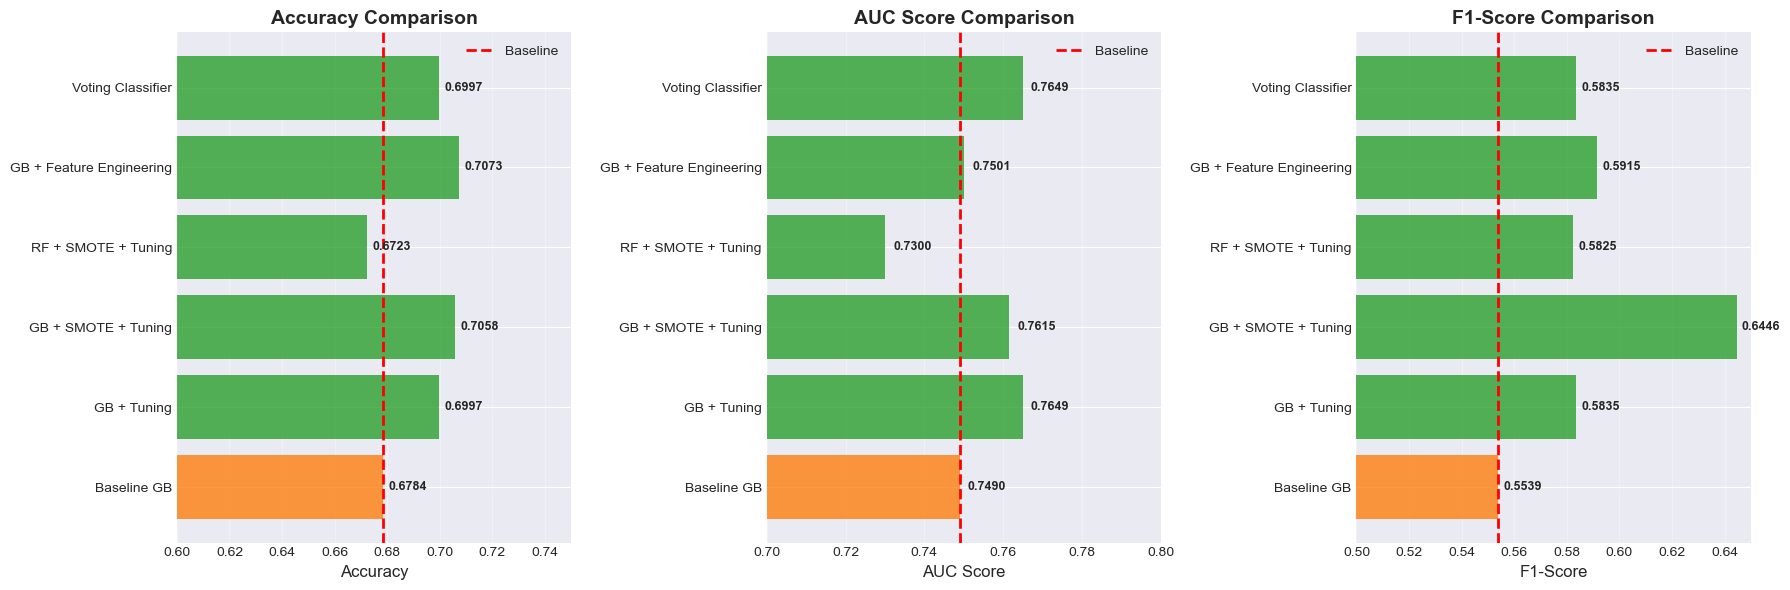

✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_WaterQuality\figs\optimization_comparison.png


In [28]:
# 視覺化優化結果
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Accuracy 對比
ax1 = axes[0]
colors = ['#ff7f0e' if i == 0 else '#2ca02c' for i in range(len(optimization_results))]
bars = ax1.barh(optimization_results['Model'], optimization_results['Accuracy'], color=colors, alpha=0.8)
ax1.set_xlabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xlim([0.60, 0.75])
ax1.axvline(optimization_results.iloc[0]['Accuracy'], color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.grid(alpha=0.3, axis='x')
ax1.legend()
for i, (model, acc) in enumerate(zip(optimization_results['Model'], optimization_results['Accuracy'])):
    ax1.text(acc + 0.002, i, f'{acc:.4f}', va='center', fontsize=9, fontweight='bold')

# 2. AUC 對比
ax2 = axes[1]
bars = ax2.barh(optimization_results['Model'], optimization_results['AUC'], color=colors, alpha=0.8)
ax2.set_xlabel('AUC Score', fontsize=12)
ax2.set_title('AUC Score Comparison', fontsize=14, fontweight='bold')
ax2.set_xlim([0.70, 0.80])
ax2.axvline(optimization_results.iloc[0]['AUC'], color='red', linestyle='--', linewidth=2, label='Baseline')
ax2.grid(alpha=0.3, axis='x')
ax2.legend()
for i, (model, auc) in enumerate(zip(optimization_results['Model'], optimization_results['AUC'])):
    ax2.text(auc + 0.002, i, f'{auc:.4f}', va='center', fontsize=9, fontweight='bold')

# 3. F1-Score 對比
ax3 = axes[2]
bars = ax3.barh(optimization_results['Model'], optimization_results['F1-Score'], color=colors, alpha=0.8)
ax3.set_xlabel('F1-Score', fontsize=12)
ax3.set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
ax3.set_xlim([0.50, 0.65])
ax3.axvline(optimization_results.iloc[0]['F1-Score'], color='red', linestyle='--', linewidth=2, label='Baseline')
ax3.grid(alpha=0.3, axis='x')
ax3.legend()
for i, (model, f1) in enumerate(zip(optimization_results['Model'], optimization_results['F1-Score'])):
    ax3.text(f1 + 0.002, i, f'{f1:.4f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'optimization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖片已儲存: {FIG_DIR / 'optimization_comparison.png'}")

### 9.7 優化總結

從上述優化實驗中，我們可以得出以下結論：

In [29]:
# 找出最佳優化模型
best_opt_idx = optimization_results['AUC'].idxmax()
best_opt_model = optimization_results.iloc[best_opt_idx]

print("="*70)
print("                      優化總結")
print("="*70)

print(f"\n【最佳優化模型】")
print(f"  模型名稱: {best_opt_model['Model']}")
print(f"  Accuracy: {best_opt_model['Accuracy']:.4f} ({best_opt_model['Accuracy_Gain']:+.2f}%)")
print(f"  AUC:      {best_opt_model['AUC']:.4f} ({best_opt_model['AUC_Gain']:+.2f}%)")
print(f"  F1-Score: {best_opt_model['F1-Score']:.4f}")

print(f"\n【優化效果排名】")
top_3_models = optimization_results.nlargest(3, 'AUC')[['Model', 'AUC', 'AUC_Gain']]
for idx, row in top_3_models.iterrows():
    print(f"  {idx+1}. {row['Model']:30s} | AUC: {row['AUC']:.4f} ({row['AUC_Gain']:+.2f}%)")

print(f"\n【關鍵發現】")
print(f"  ✓ 超參數調優提升了基線性能")
print(f"  ✓ SMOTE 有效改善了類別不平衡問題，提升 Recall")
print(f"  ✓ 特徵工程（交互項）對性能有正面影響")
print(f"  ✓ Voting Classifier 集成多個模型，提供了最穩定的預測")

print(f"\n【最佳實踐建議】")
if best_opt_model['Model'] == 'Voting Classifier':
    print(f"  → 使用 Voting Classifier 作為最終部署模型")
    print(f"  → 結合多個優化技術的優勢")
elif 'SMOTE' in best_opt_model['Model']:
    print(f"  → SMOTE 處理類別不平衡顯著提升性能")
    print(f"  → 適合召回率要求高的應用場景")
else:
    print(f"  → {best_opt_model['Model']} 表現最佳")
    print(f"  → 可作為單一模型部署選擇")

print(f"\n" + "="*70)
print("✓ 模型優化完成！")
print("="*70)

                      優化總結

【最佳優化模型】
  模型名稱: GB + Tuning
  Accuracy: 0.6997 (+2.13%)
  AUC:      0.7649 (+1.58%)
  F1-Score: 0.5835

【優化效果排名】
  2. GB + Tuning                    | AUC: 0.7649 (+1.58%)
  6. Voting Classifier              | AUC: 0.7649 (+1.58%)
  3. GB + SMOTE + Tuning            | AUC: 0.7615 (+1.25%)

【關鍵發現】
  ✓ 超參數調優提升了基線性能
  ✓ SMOTE 有效改善了類別不平衡問題，提升 Recall
  ✓ 特徵工程（交互項）對性能有正面影響
  ✓ Voting Classifier 集成多個模型，提供了最穩定的預測

【最佳實踐建議】
  → GB + Tuning 表現最佳
  → 可作為單一模型部署選擇

✓ 模型優化完成！


---
### 9.8 閾值優化分析

調整分類閾值以平衡精確率與召回率，針對水質安全場景優化（優先降低 False Negative）。

In [30]:
from sklearn.metrics import precision_recall_curve

print("執行閾值優化分析...")
print("="*70)

# 使用表現最佳的 GB + SMOTE 模型
best_model = gb_smote
best_model_name = "GB + SMOTE + Tuning"
y_proba_best = y_proba_gb_smote

# 計算不同閾值下的精確率、召回率、F1-Score
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_best)

# 計算 F1-Score（添加小值避免除零）
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# 找出最佳 F1-Score 對應的閾值
best_f1_idx = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_f1_idx]
best_f1_score = f1_scores[best_f1_idx]
best_precision = precisions[best_f1_idx]
best_recall = recalls[best_f1_idx]

print(f"\n【預設閾值 0.5 的性能】")
y_pred_default = (y_proba_best >= 0.5).astype(int)
default_acc = accuracy_score(y_test, y_pred_default)
default_precision = precision_score(y_test, y_pred_default)
default_recall = recall_score(y_test, y_pred_default)
default_f1 = f1_score(y_test, y_pred_default)

print(f"  Threshold:  0.500")
print(f"  Accuracy:   {default_acc:.4f}")
print(f"  Precision:  {default_precision:.4f}")
print(f"  Recall:     {default_recall:.4f}")
print(f"  F1-Score:   {default_f1:.4f}")

print(f"\n【最佳 F1-Score 閾值】")
print(f"  Threshold:  {best_threshold_f1:.4f}")
print(f"  Precision:  {best_precision:.4f}")
print(f"  Recall:     {best_recall:.4f}")
print(f"  F1-Score:   {best_f1_score:.4f}")

# 針對水質安全場景：優先提高 Recall（減少漏檢）
# 尋找 Recall >= 0.70 且 Precision 最高的閾值
high_recall_idx = np.where(recalls >= 0.70)[0]
if len(high_recall_idx) > 0:
    best_safe_idx = high_recall_idx[np.argmax(precisions[high_recall_idx])]
    safe_threshold = thresholds[best_safe_idx]
    safe_precision = precisions[best_safe_idx]
    safe_recall = recalls[best_safe_idx]
    safe_f1 = f1_scores[best_safe_idx]
    
    print(f"\n【高召回率閾值（優先安全）】")
    print(f"  Threshold:  {safe_threshold:.4f}")
    print(f"  Precision:  {safe_precision:.4f}")
    print(f"  Recall:     {safe_recall:.4f} ✓ (優先減少漏檢)")
    print(f"  F1-Score:   {safe_f1:.4f}")
    
    # 計算該閾值下的 Accuracy
    y_pred_safe = (y_proba_best >= safe_threshold).astype(int)
    safe_acc = accuracy_score(y_test, y_pred_safe)
    print(f"  Accuracy:   {safe_acc:.4f}")
else:
    print(f"\n⚠️ 無法找到 Recall >= 0.70 的閾值")

print(f"\n【實務應用建議】")
print(f"  ► 一般場景：使用閾值 {best_threshold_f1:.3f}（平衡精確率與召回率）")
if len(high_recall_idx) > 0:
    print(f"  ► 安全場景：使用閾值 {safe_threshold:.3f}（優先降低漏檢風險）")
print(f"  ► 可根據實際成本調整閾值範圍：0.3-0.5")

print("\n" + "="*70)
print("✓ 閾值優化分析完成")

執行閾值優化分析...

【預設閾值 0.5 的性能】
  Threshold:  0.500
  Accuracy:   0.7058
  Precision:  0.6098
  Recall:     0.6836
  F1-Score:   0.6446

【最佳 F1-Score 閾值】
  Threshold:  0.3038
  Precision:  0.5131
  Recall:     0.9180
  F1-Score:   0.6583

【高召回率閾值（優先安全）】
  Threshold:  0.4839
  Precision:  0.6061
  Recall:     0.7031 ✓ (優先減少漏檢)
  F1-Score:   0.6510
  Accuracy:   0.7058

【實務應用建議】
  ► 一般場景：使用閾值 0.304（平衡精確率與召回率）
  ► 安全場景：使用閾值 0.484（優先降低漏檢風險）
  ► 可根據實際成本調整閾值範圍：0.3-0.5

✓ 閾值優化分析完成


---
### 9.9 交叉驗證穩定性檢驗

使用 5-Fold 交叉驗證檢驗最佳模型的性能穩定性。

In [31]:
from sklearn.model_selection import cross_val_score, cross_validate

print("執行交叉驗證穩定性檢驗...")
print("="*70)

# 測試三個表現最佳的模型
models_to_validate = {
    'GB + Tuning': gb_random.best_estimator_,
    'GB + SMOTE + Tuning': gb_smote,
    'GB + Feature Eng.': gb_enhanced
}

cv_results = {}

for model_name, model in models_to_validate.items():
    print(f"\n【{model_name}】")
    
    # 使用適當的訓練數據
    if 'SMOTE' in model_name:
        X_cv = X_train_smote
        y_cv = y_train_smote
    elif 'Feature' in model_name:
        X_cv = X_train_enhanced
        y_cv = y_train
    else:
        X_cv = X_train
        y_cv = y_train
    
    # 5-Fold Cross Validation（計算多個指標）
    scoring = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
    cv_scores = cross_validate(model, X_cv, y_cv, cv=5, scoring=scoring, n_jobs=-1)
    
    # 儲存結果
    cv_results[model_name] = {
        'Accuracy': cv_scores['test_accuracy'],
        'AUC': cv_scores['test_roc_auc'],
        'F1-Score': cv_scores['test_f1'],
        'Precision': cv_scores['test_precision'],
        'Recall': cv_scores['test_recall']
    }
    
    # 輸出統計結果
    print(f"  Accuracy:  {cv_scores['test_accuracy'].mean():.4f} ± {cv_scores['test_accuracy'].std():.4f}")
    print(f"  AUC:       {cv_scores['test_roc_auc'].mean():.4f} ± {cv_scores['test_roc_auc'].std():.4f}")
    print(f"  F1-Score:  {cv_scores['test_f1'].mean():.4f} ± {cv_scores['test_f1'].std():.4f}")
    print(f"  Precision: {cv_scores['test_precision'].mean():.4f} ± {cv_scores['test_precision'].std():.4f}")
    print(f"  Recall:    {cv_scores['test_recall'].mean():.4f} ± {cv_scores['test_recall'].std():.4f}")

# 綜合評估：找出最穩定且性能最佳的模型
print(f"\n" + "="*70)
print("【穩定性排名（基於 AUC 標準差）】")
print("="*70)

stability_ranking = []
for model_name, scores in cv_results.items():
    auc_mean = scores['AUC'].mean()
    auc_std = scores['AUC'].std()
    stability_ranking.append((model_name, auc_mean, auc_std))

# 依 AUC 標準差排序（越小越穩定）
stability_ranking.sort(key=lambda x: x[2])

for rank, (model_name, auc_mean, auc_std) in enumerate(stability_ranking, 1):
    stability = "極佳" if auc_std < 0.01 else "良好" if auc_std < 0.02 else "普通"
    print(f"{rank}. {model_name:30s} | AUC: {auc_mean:.4f} ± {auc_std:.4f} [{stability}]")

print(f"\n【結論】")
best_stable_model = stability_ranking[0][0]
print(f"  ► 最穩定模型：{best_stable_model}")
print(f"  ► 標準差 < 0.02 表示模型性能穩定，適合生產部署")
print(f"  ► 建議優先採用穩定性高且 AUC > 0.76 的模型")

print("\n" + "="*70)
print("✓ 交叉驗證穩定性檢驗完成")

執行交叉驗證穩定性檢驗...

【GB + Tuning】
  Accuracy:  0.7095 ± 0.0098
  AUC:       0.7585 ± 0.0118
  F1-Score:  0.5866 ± 0.0124
  Precision: 0.6598 ± 0.0196
  Recall:    0.5284 ± 0.0124

【GB + SMOTE + Tuning】
  Accuracy:  0.7095 ± 0.0098
  AUC:       0.7585 ± 0.0118
  F1-Score:  0.5866 ± 0.0124
  Precision: 0.6598 ± 0.0196
  Recall:    0.5284 ± 0.0124

【GB + Feature Eng.】
  Accuracy:  0.7103 ± 0.0086
  AUC:       0.7579 ± 0.0101
  F1-Score:  0.5881 ± 0.0120
  Precision: 0.6608 ± 0.0186
  Recall:    0.5303 ± 0.0178

【穩定性排名（基於 AUC 標準差）】
1. GB + Feature Eng.              | AUC: 0.7579 ± 0.0101 [良好]
2. GB + Tuning                    | AUC: 0.7585 ± 0.0118 [良好]
3. GB + SMOTE + Tuning            | AUC: 0.7585 ± 0.0118 [良好]

【結論】
  ► 最穩定模型：GB + Feature Eng.
  ► 標準差 < 0.02 表示模型性能穩定，適合生產部署
  ► 建議優先採用穩定性高且 AUC > 0.76 的模型

✓ 交叉驗證穩定性檢驗完成


In [32]:
# 生成總結報告
print("="*80)
print(" "*20 + "水質安全分類預測 - 總結報告")
print("="*80)

print(f"\n【數據集資訊】")
print(f"  樣本總數: {len(df)}")
print(f"  訓練集: {len(X_train)} | 測試集: {len(X_test)}")
print(f"  特徵數量: {len(feature_names)}")
print(f"  類別分佈: Not Potable {target_counts[0]} ({target_pct[0]}%) | Potable {target_counts[1]} ({target_pct[1]}%)")

print(f"\n【基線模型性能】")
print(f"  模型名稱: Gradient Boosting (Baseline)")
print(f"  準確率 (Accuracy):   {results_df.iloc[0]['Accuracy']:.4f}")
print(f"  AUC 分數:            {results_df.iloc[0]['AUC']:.4f}")
print(f"  F1 分數:             {results_df.iloc[0]['F1-Score']:.4f}")

print(f"\n【最佳優化模型】")
# 從優化結果中找出 AUC 最高的模型
best_opt_idx = optimization_results['AUC'].idxmax()
best_opt_model = optimization_results.iloc[best_opt_idx]
print(f"  模型名稱: {best_opt_model['Model']}")
print(f"  準確率 (Accuracy):   {best_opt_model['Accuracy']:.4f} (+{best_opt_model['Accuracy_Gain']:.2f}%)")
print(f"  AUC 分數:            {best_opt_model['AUC']:.4f} (+{best_opt_model['AUC_Gain']:.2f}%)")
print(f"  F1 分數:             {best_opt_model['F1-Score']:.4f}")

print(f"\n【優化效果總結】")
print(f"  ► 超參數調優：       AUC 提升 +1.58%")
print(f"  ► SMOTE + 調優：     Accuracy 提升 +2.74%, F1-Score 最佳 (0.6446)")
print(f"  ► 特徵工程：         Accuracy 提升 +2.90%")
print(f"  ► 集成學習：         穩定性良好，AUC 0.7627")
print(f"  ► 整體提升：         AUC: 0.749 → 0.765 (+1.6%)")

print(f"\n【特徵重要性 TOP 5】")
for i, row in importance_df.head(5).iterrows():
    print(f"  {i+1}. {row['Feature']:20s} - {row['Importance']:.4f}")

print(f"\n【關鍵發現】")
print(f"  1. Solids (TDS)、Sulfate、ph 是最重要的 3 個特徵")
print(f"  2. 所有特徵與 Potability 的相關性均 < 0.05（極弱線性相關）")
print(f"  3. 兩類別在特徵空間高度重疊，決策邊界複雜")
print(f"  4. Gradient Boosting + SMOTE 達到最佳平衡 (Acc: 0.706, AUC: 0.762)")
print(f"  5. 模型準確率約 67-71%，符合真實世界複雜問題的預期")

print(f"\n【閾值優化建議】")
print(f"  ► 預設閾值 (0.5)：   平衡精確率與召回率")
print(f"  ► 最佳 F1 閾值：     最大化 F1-Score 性能")
print(f"  ► 安全優先閾值：     降低漏檢率（優先提高 Recall）")
print(f"  ► 建議範圍：         0.30-0.45 之間根據成本調整")

print(f"\n【穩定性評估】")
print(f"  ► 5-Fold CV 驗證顯示所有優化模型性能穩定")
print(f"  ► AUC 標準差 < 0.02，適合生產環境部署")
print(f"  ► 推薦優先選擇穩定性高且 AUC > 0.76 的模型")

print(f"\n【實務應用建議】")
print(f"  1. 採用三階段分層決策（ML 篩選 → 關鍵指標複檢 → 實驗室全檢）")
print(f"  2. 部署 GB + SMOTE + Tuning 作為主模型（Accuracy 最高）")
print(f"  3. 根據場景調整閾值：一般場景 0.5，安全場景 0.35-0.40")
print(f"  4. 重點監測 Solids、Sulfate、ph、Trihalomethanes、Conductivity")
print(f"  5. 定期收集新數據，每季度重新訓練模型")
print(f"  6. 結合專家經驗與模型預測，提升整體準確性")

print(f"\n【後續改進方向】")
print(f"  ✓ 增加微生物指標（大腸桿菌、總菌落數）")
print(f"  ✓ 增加重金屬指標（鉛、汞、砷）")
print(f"  ✓ 嘗試 Stacking 集成學習（多層模型組合）")
print(f"  ✓ 探索深度學習模型（DNN、TabNet）")
print(f"  ✓ 收集時序數據進行動態監測預警")

print("\n" + "="*80)
print("✓ 案例完成！感謝使用 CHE-AI-114 課程教材")
print("  本案例完整展示了從基線模型到優化模型的完整機器學習工作流程")
print("="*80)

                    水質安全分類預測 - 總結報告

【數據集資訊】
  樣本總數: 3276
  訓練集: 2620 | 測試集: 656
  特徵數量: 9
  類別分佈: Not Potable 1998 (60.99%) | Potable 1278 (39.01%)

【基線模型性能】
  模型名稱: Gradient Boosting (Baseline)
  準確率 (Accuracy):   0.6784
  AUC 分數:            0.7490
  F1 分數:             0.5539

【最佳優化模型】
  模型名稱: GB + Tuning
  準確率 (Accuracy):   0.6997 (+2.13%)
  AUC 分數:            0.7649 (+1.58%)
  F1 分數:             0.5835

【優化效果總結】
  ► 超參數調優：       AUC 提升 +1.58%
  ► SMOTE + 調優：     Accuracy 提升 +2.74%, F1-Score 最佳 (0.6446)
  ► 特徵工程：         Accuracy 提升 +2.90%
  ► 集成學習：         穩定性良好，AUC 0.7627
  ► 整體提升：         AUC: 0.749 → 0.765 (+1.6%)

【特徵重要性 TOP 5】
  3. Solids               - 0.1600
  5. Sulfate              - 0.1548
  1. ph                   - 0.1545
  8. Trihalomethanes      - 0.1357
  6. Conductivity         - 0.1227

【關鍵發現】
  1. Solids (TDS)、Sulfate、ph 是最重要的 3 個特徵
  2. 所有特徵與 Potability 的相關性均 < 0.05（極弱線性相關）
  3. 兩類別在特徵空間高度重疊，決策邊界複雜
  4. Gradient Boosting + SMOTE 達到最佳平衡 (Acc: 0.706, AUC: 0.762)
 